## Подготовка данных

In [2]:
import pandas as pd
import os

data_paths = {
    'anomaly_free': 'anomaly-free.csv',
    'valve1': 'valve1',
    'valve2': 'valve2'
}

def read_csv_file(file_path):
    return pd.read_csv(file_path, sep=';', parse_dates=['datetime'])

anomaly_free_df = read_csv_file(data_paths['anomaly_free'])

valve1_dfs = [read_csv_file(os.path.join(data_paths['valve1'], f)) for f in os.listdir(data_paths['valve1']) if f.endswith('.csv')]
valve2_dfs = [read_csv_file(os.path.join(data_paths['valve2'], f)) for f in os.listdir(data_paths['valve2']) if f.endswith('.csv')]

valve1_df = pd.concat(valve1_dfs, ignore_index=True)
valve2_df = pd.concat(valve2_dfs, ignore_index=True)

print("=== Anomaly-Free Data Info ===")
print(anomaly_free_df.info())
print("\n=== Anomaly-Free Data Description ===")
print(anomaly_free_df.describe())

print("\n=== Valve1 Data Info ===")
print(valve1_df.info())
print("\n=== Valve1 Data Description ===")
print(valve1_df.describe())

print("\n=== Valve2 Data Info ===")
print(valve2_df.info())
print("\n=== Valve2 Data Description ===")
print(valve2_df.describe())


=== Anomaly-Free Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9405 entries, 0 to 9404
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             9405 non-null   datetime64[ns]
 1   Accelerometer1RMS    9405 non-null   float64       
 2   Accelerometer2RMS    9405 non-null   float64       
 3   Current              9405 non-null   float64       
 4   Pressure             9405 non-null   float64       
 5   Temperature          9405 non-null   float64       
 6   Thermocouple         9405 non-null   float64       
 7   Voltage              9405 non-null   float64       
 8   Volume Flow RateRMS  9405 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 661.4 KB
None

=== Anomaly-Free Data Description ===
                            datetime  Accelerometer1RMS  Accelerometer2RMS  \
count                           9405        9405.0000

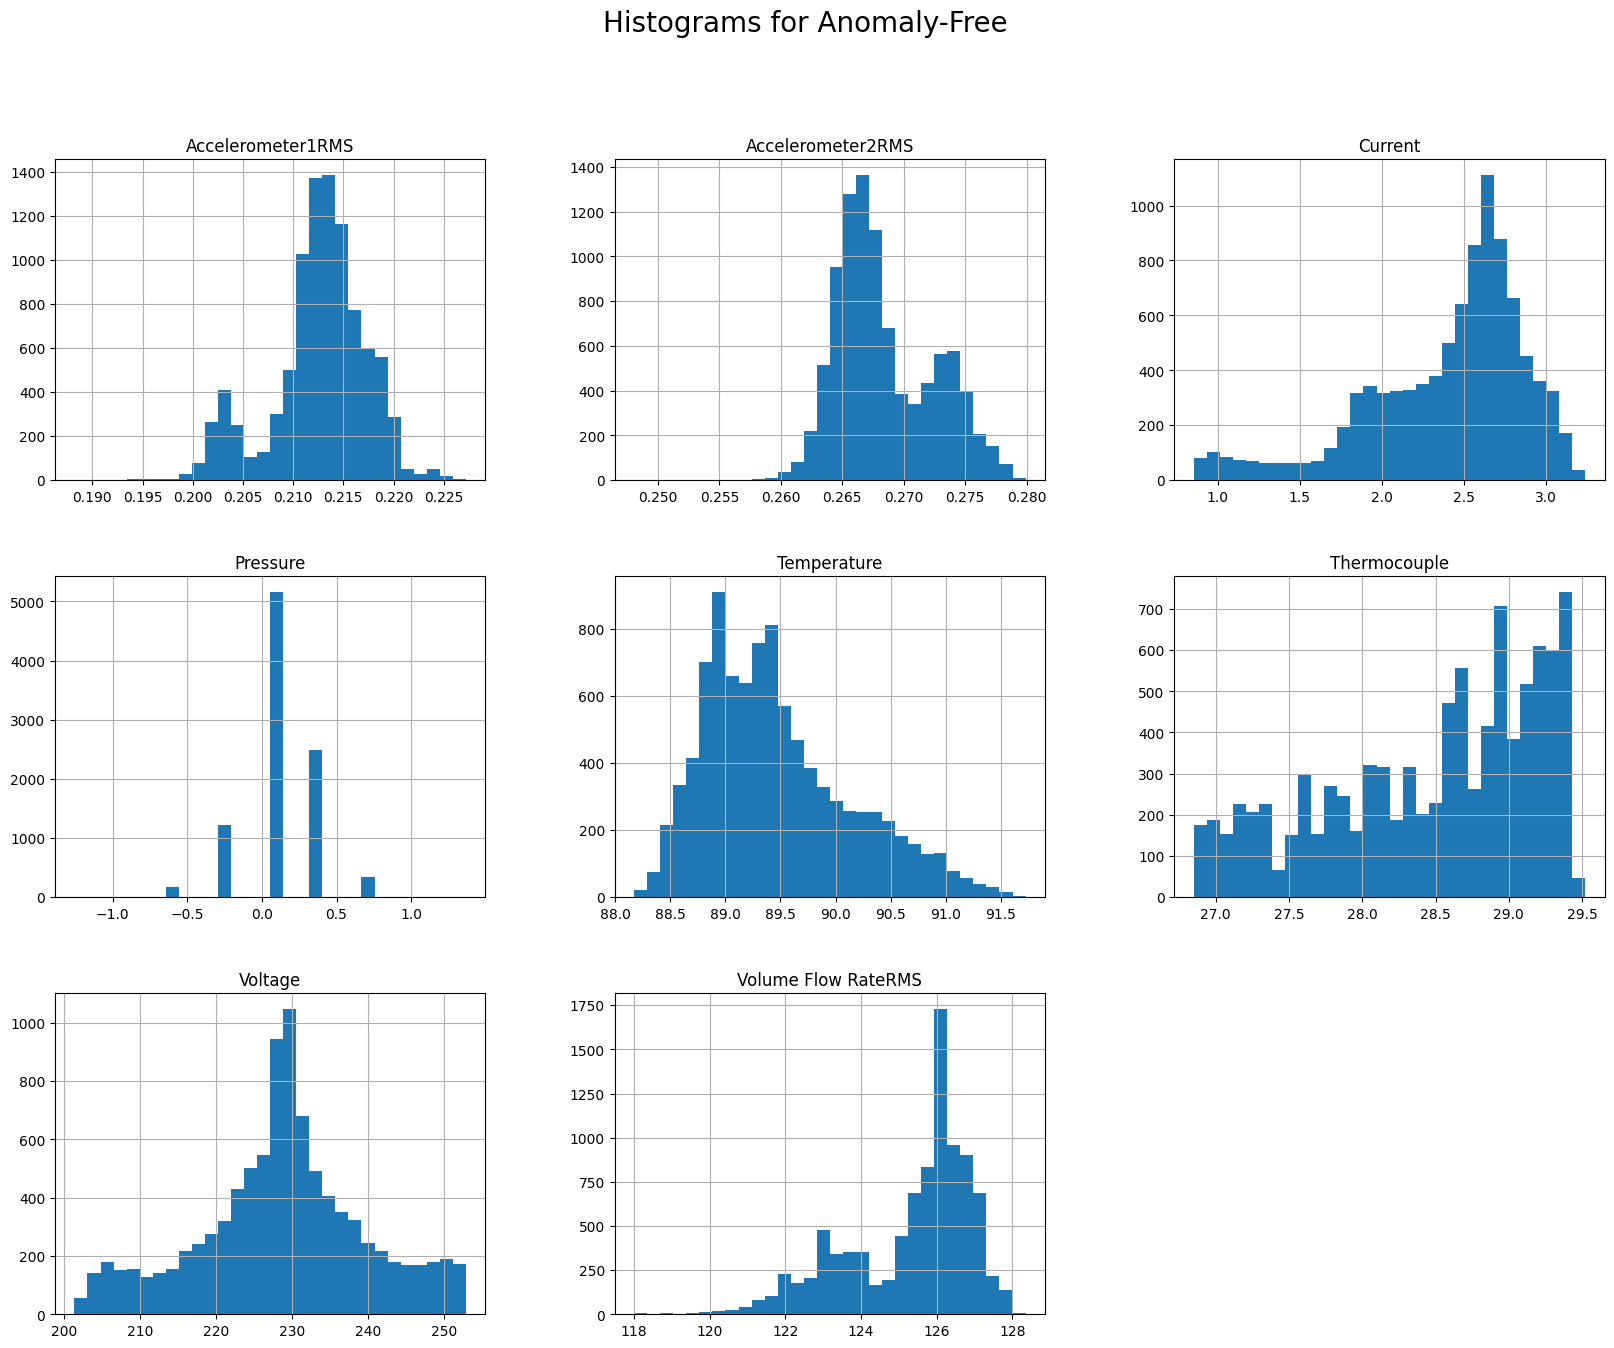

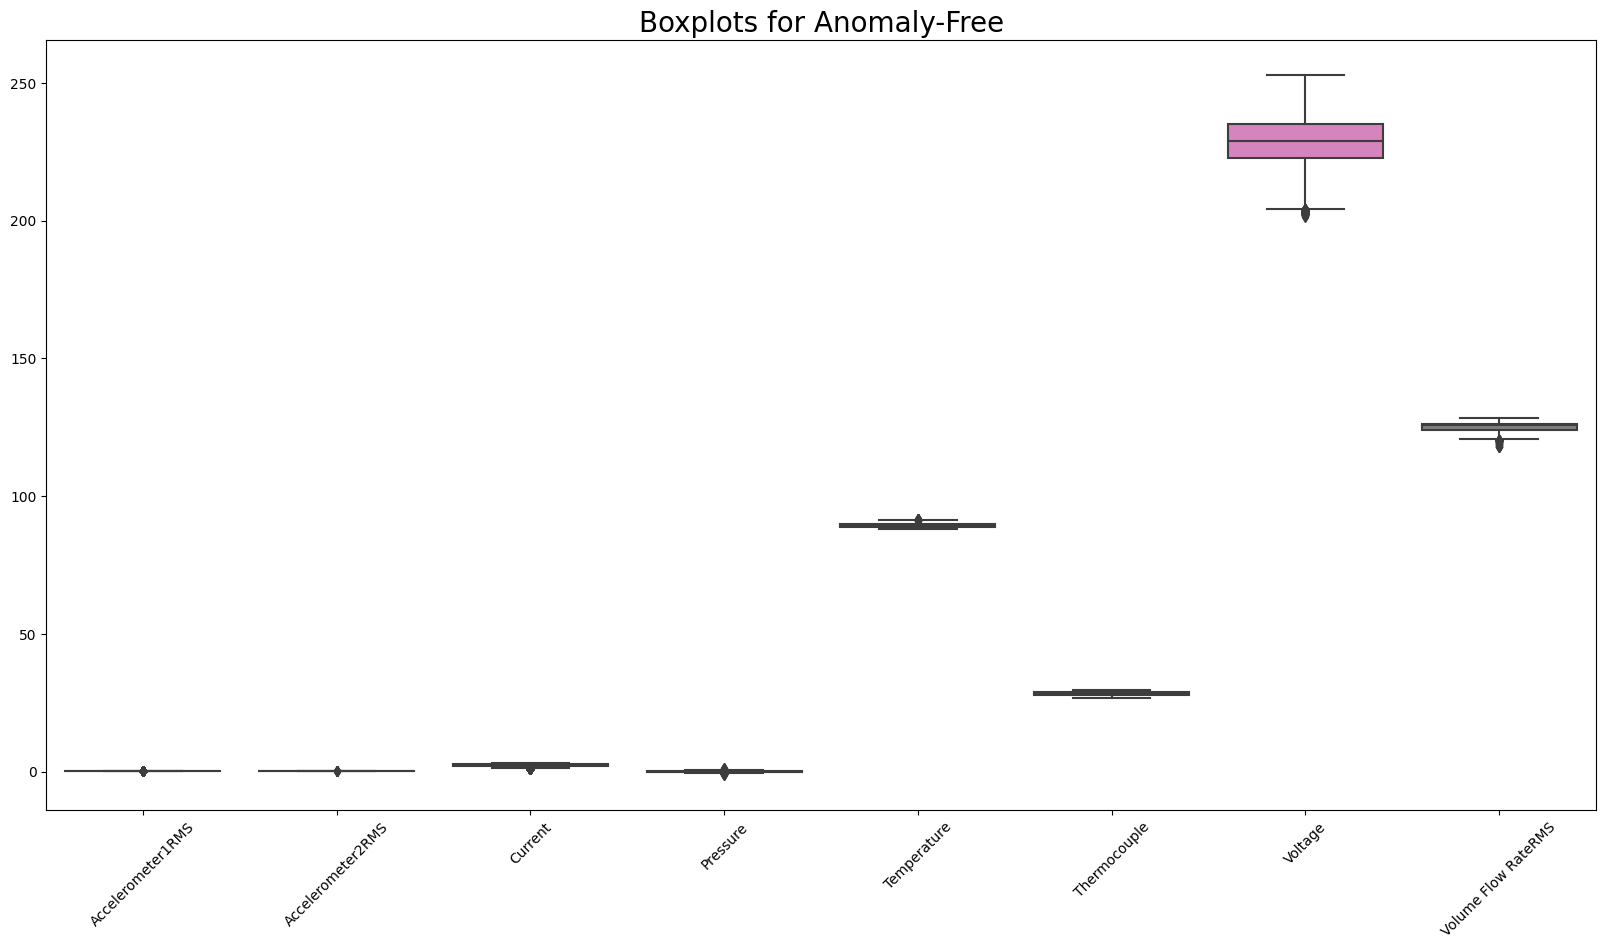

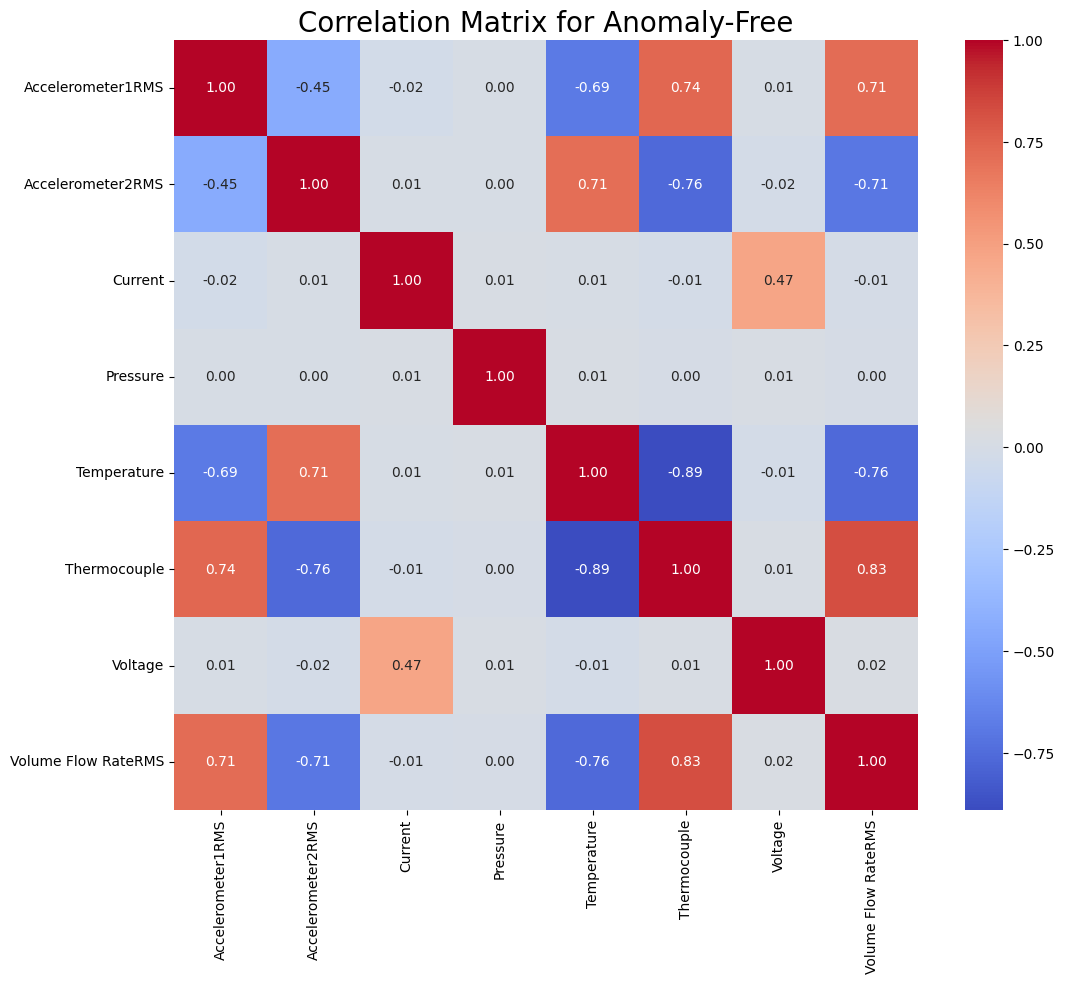

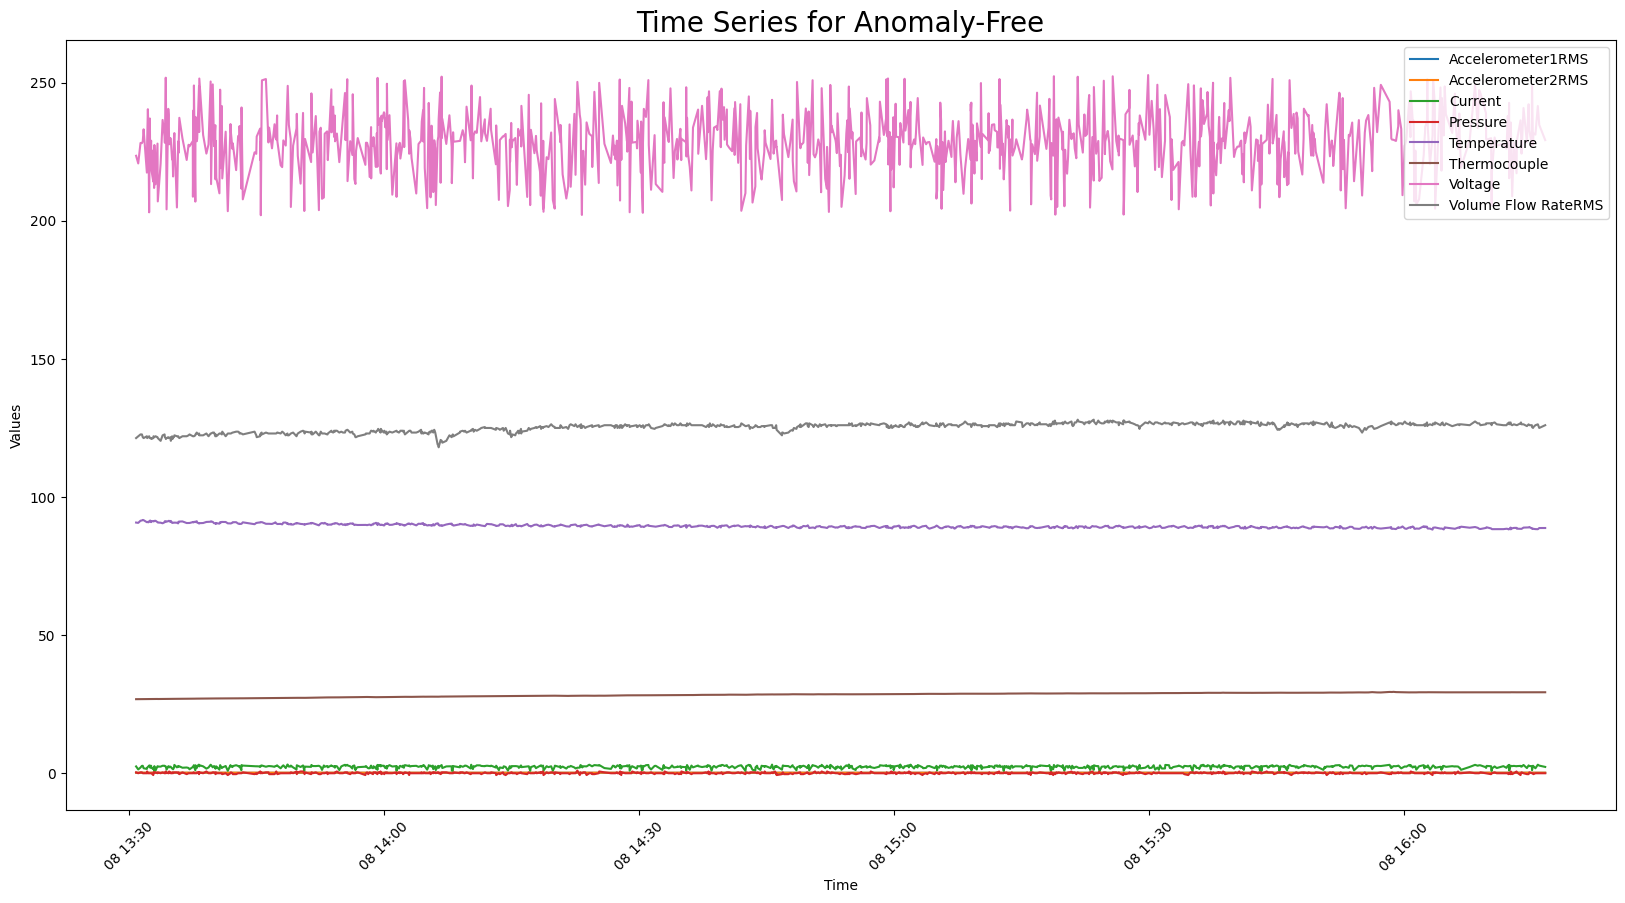

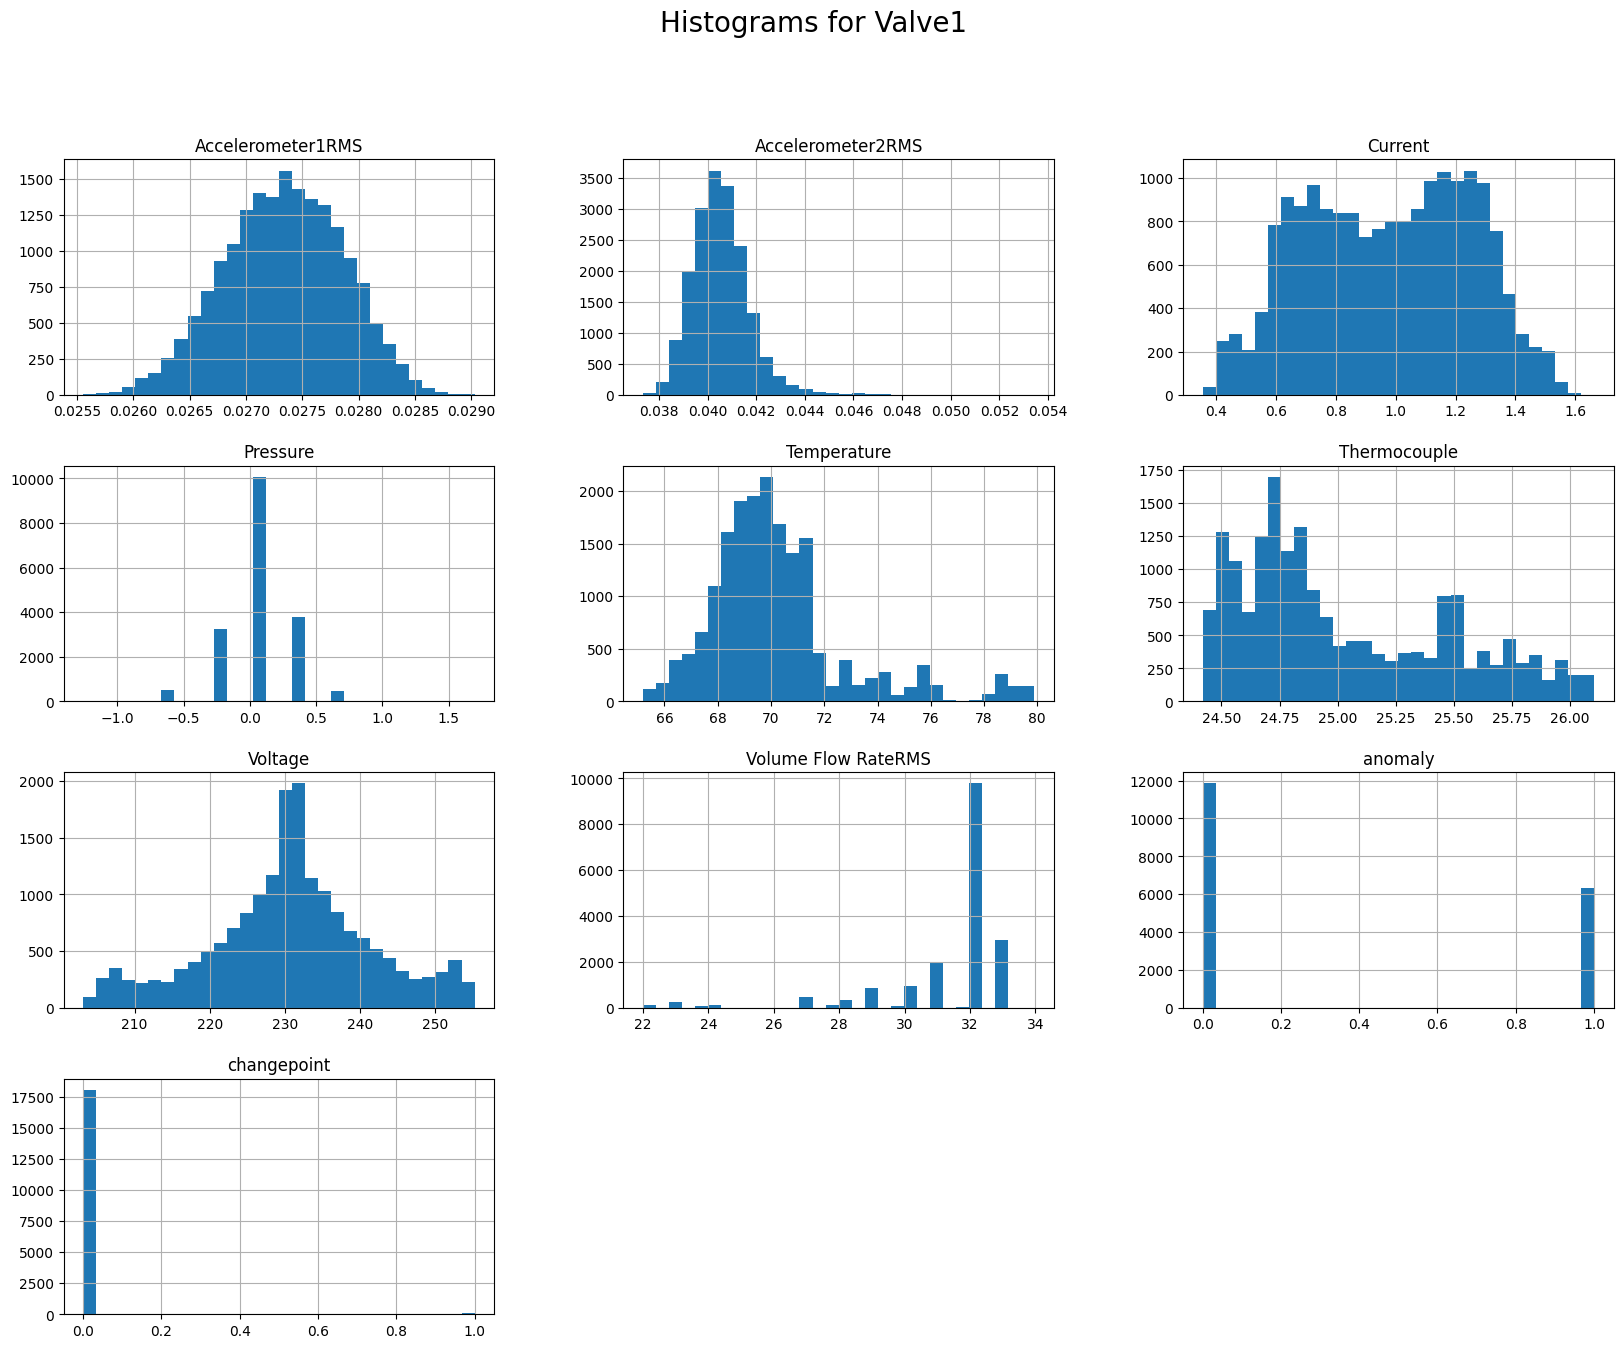

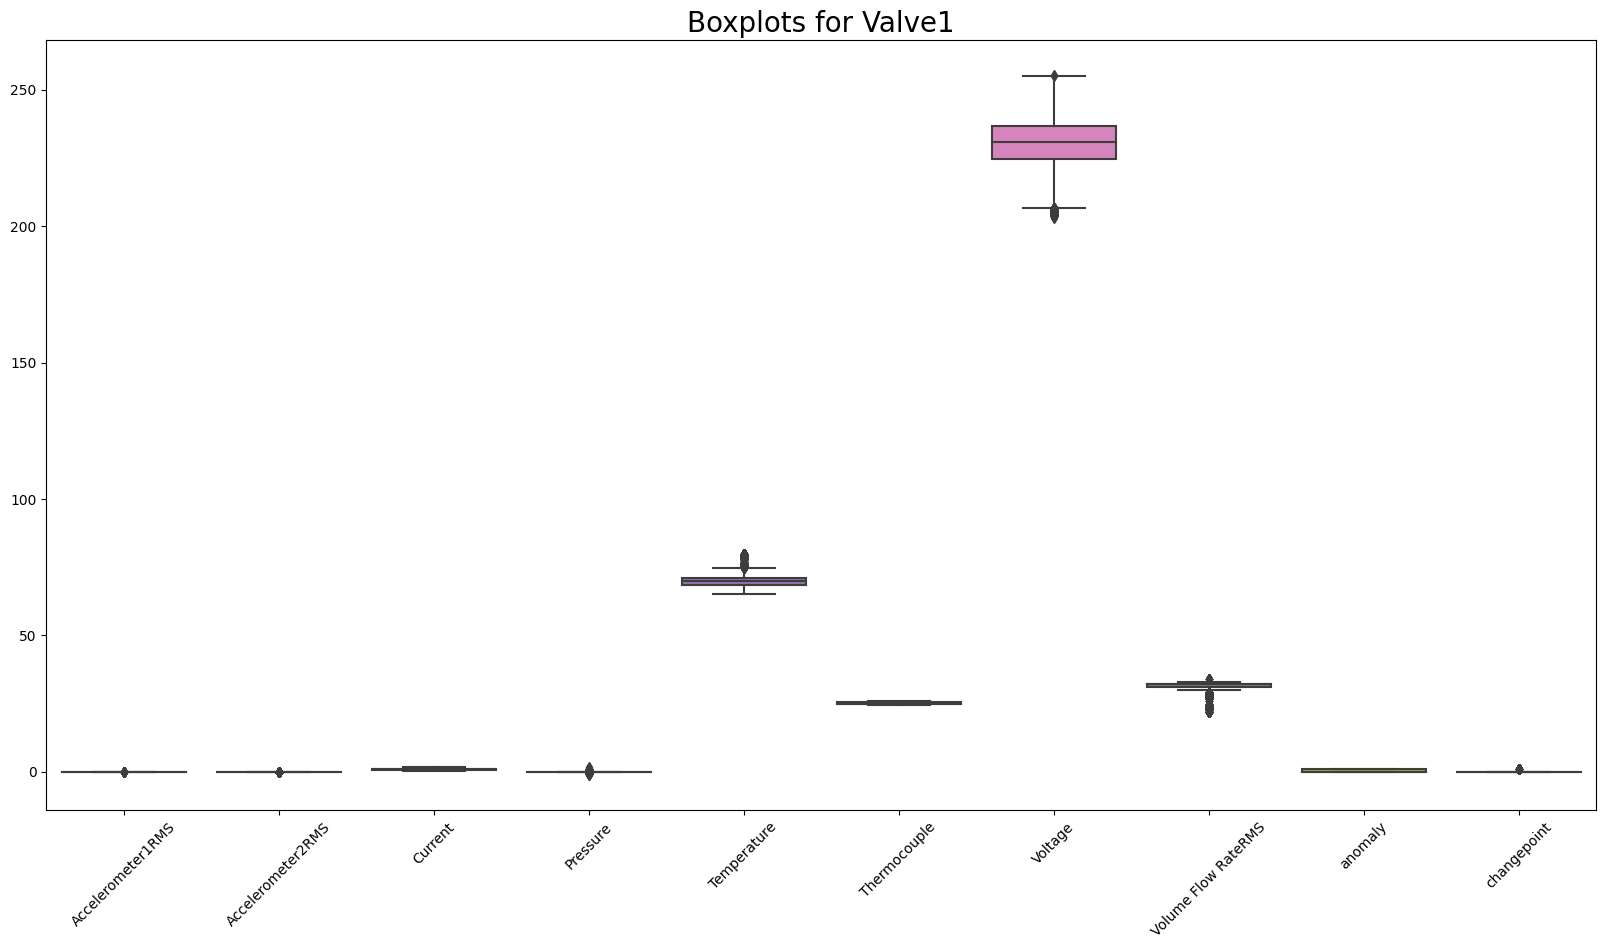

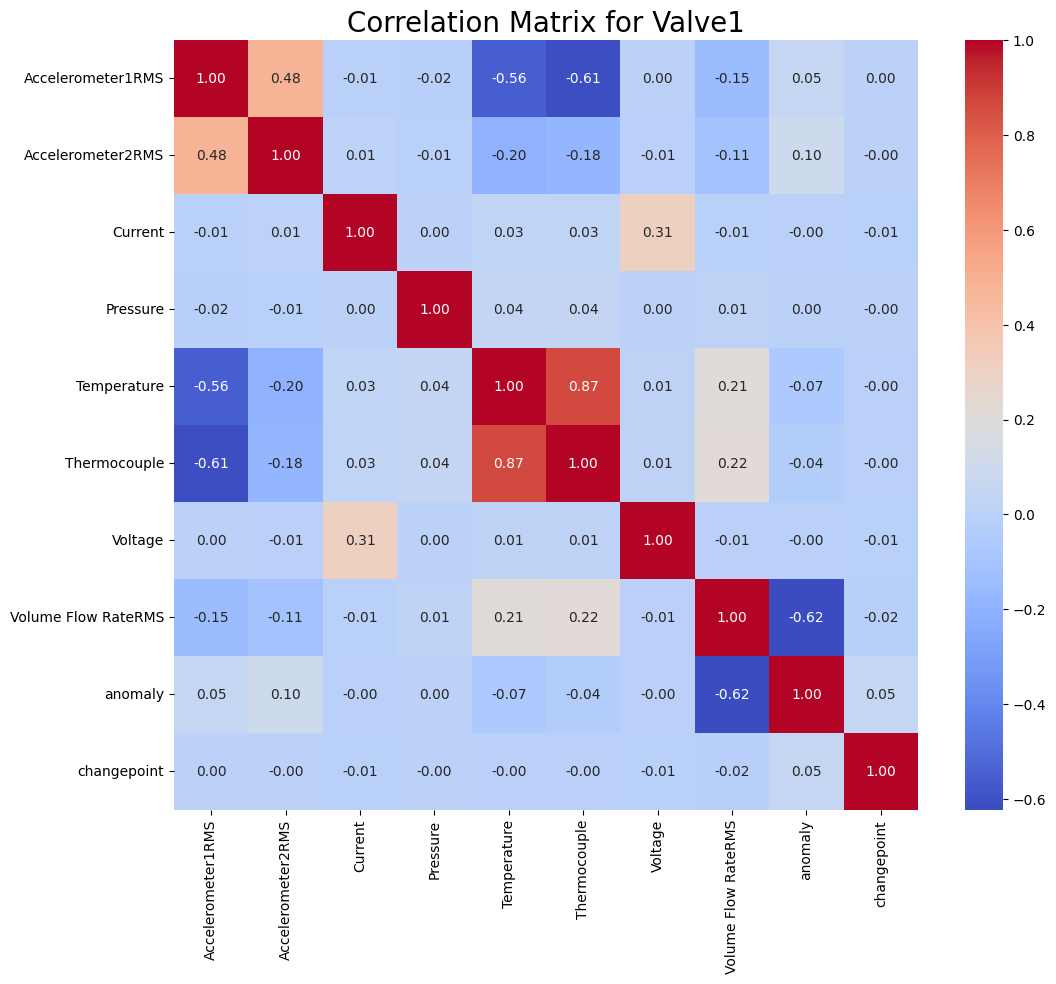

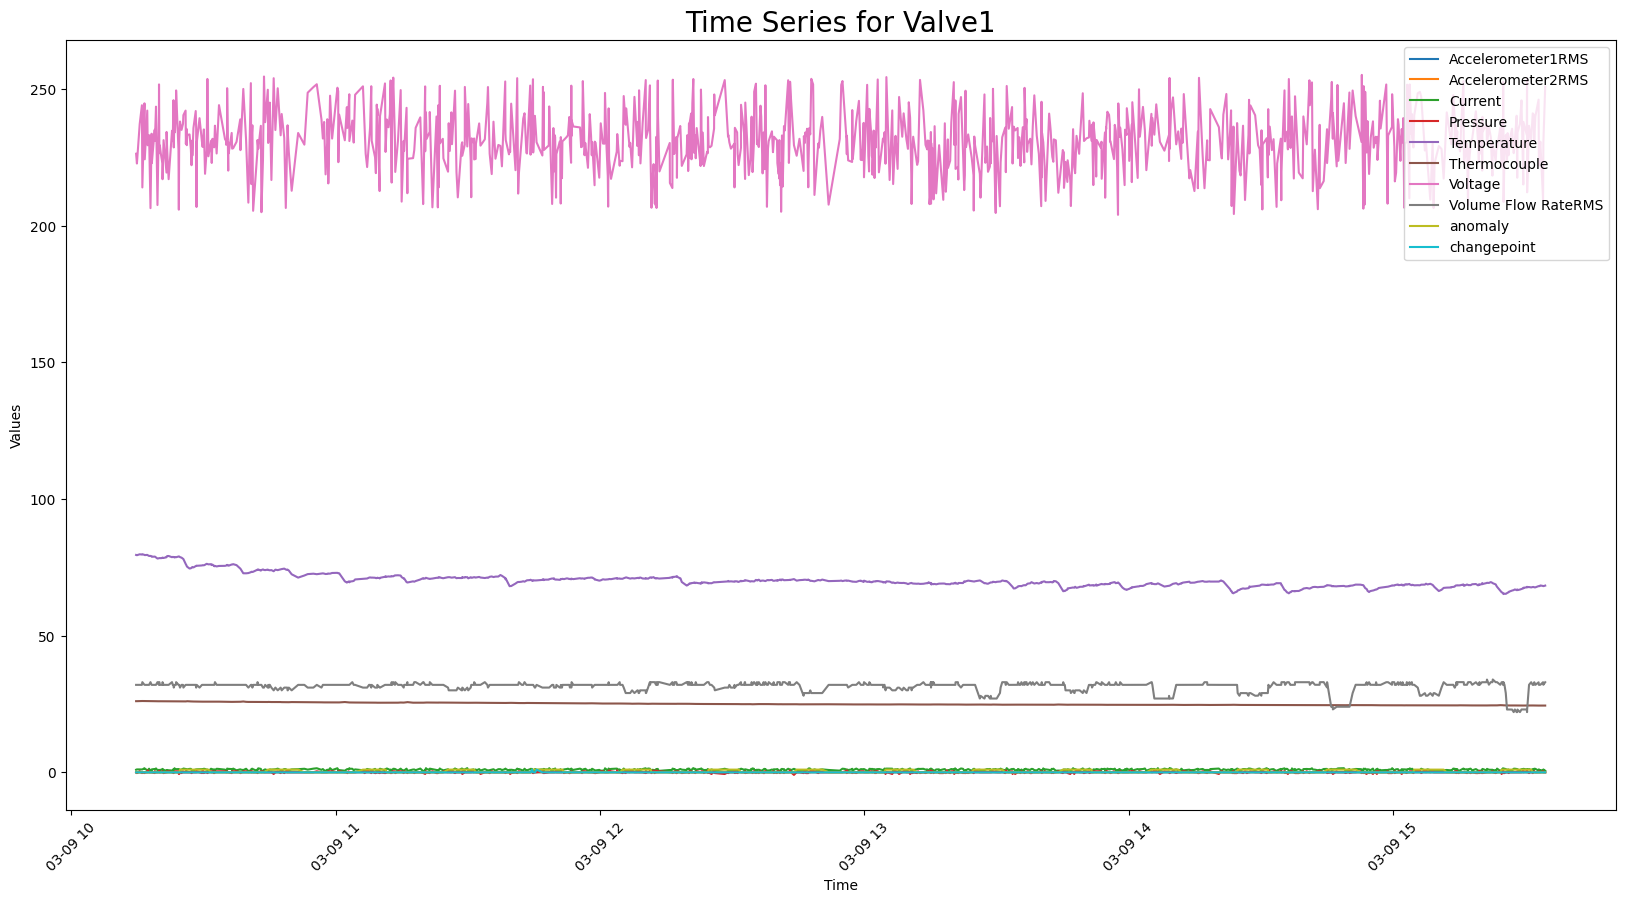

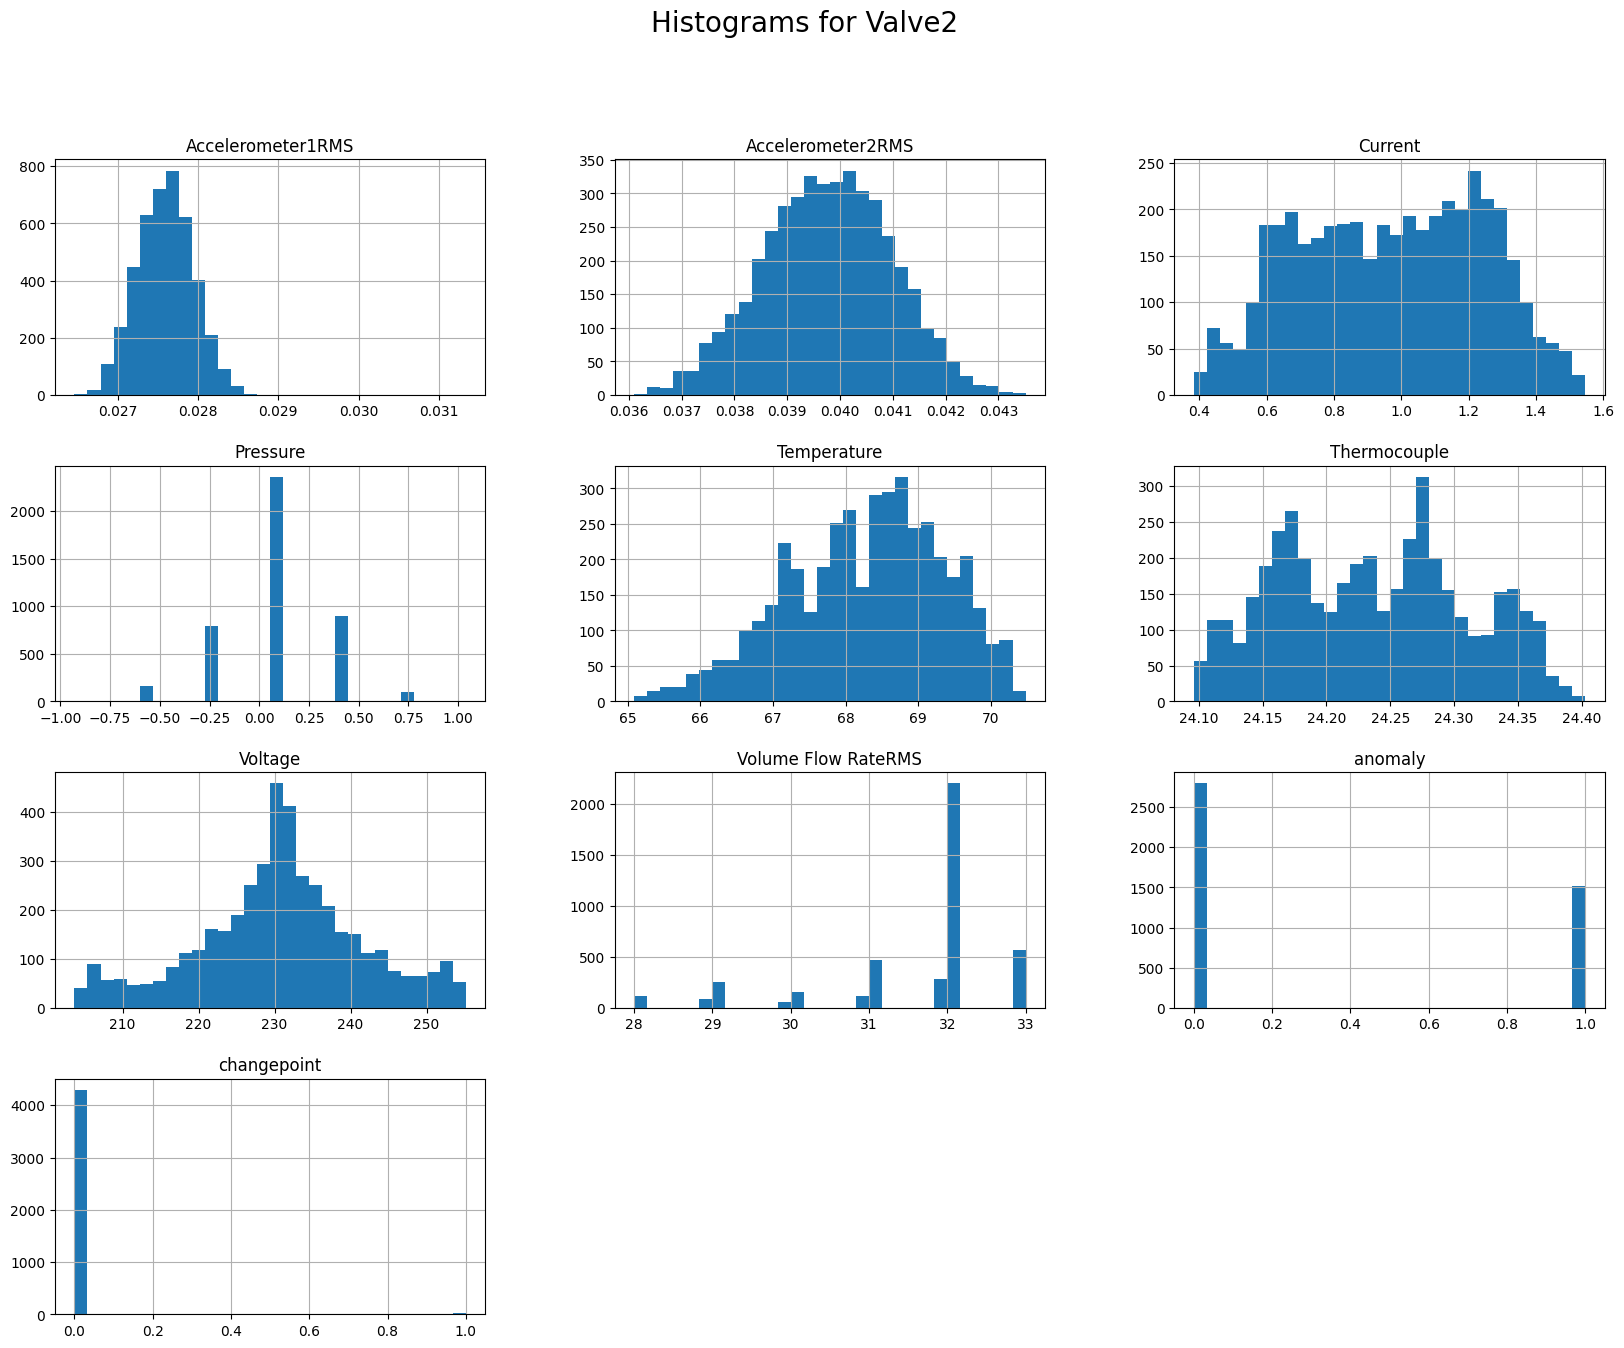

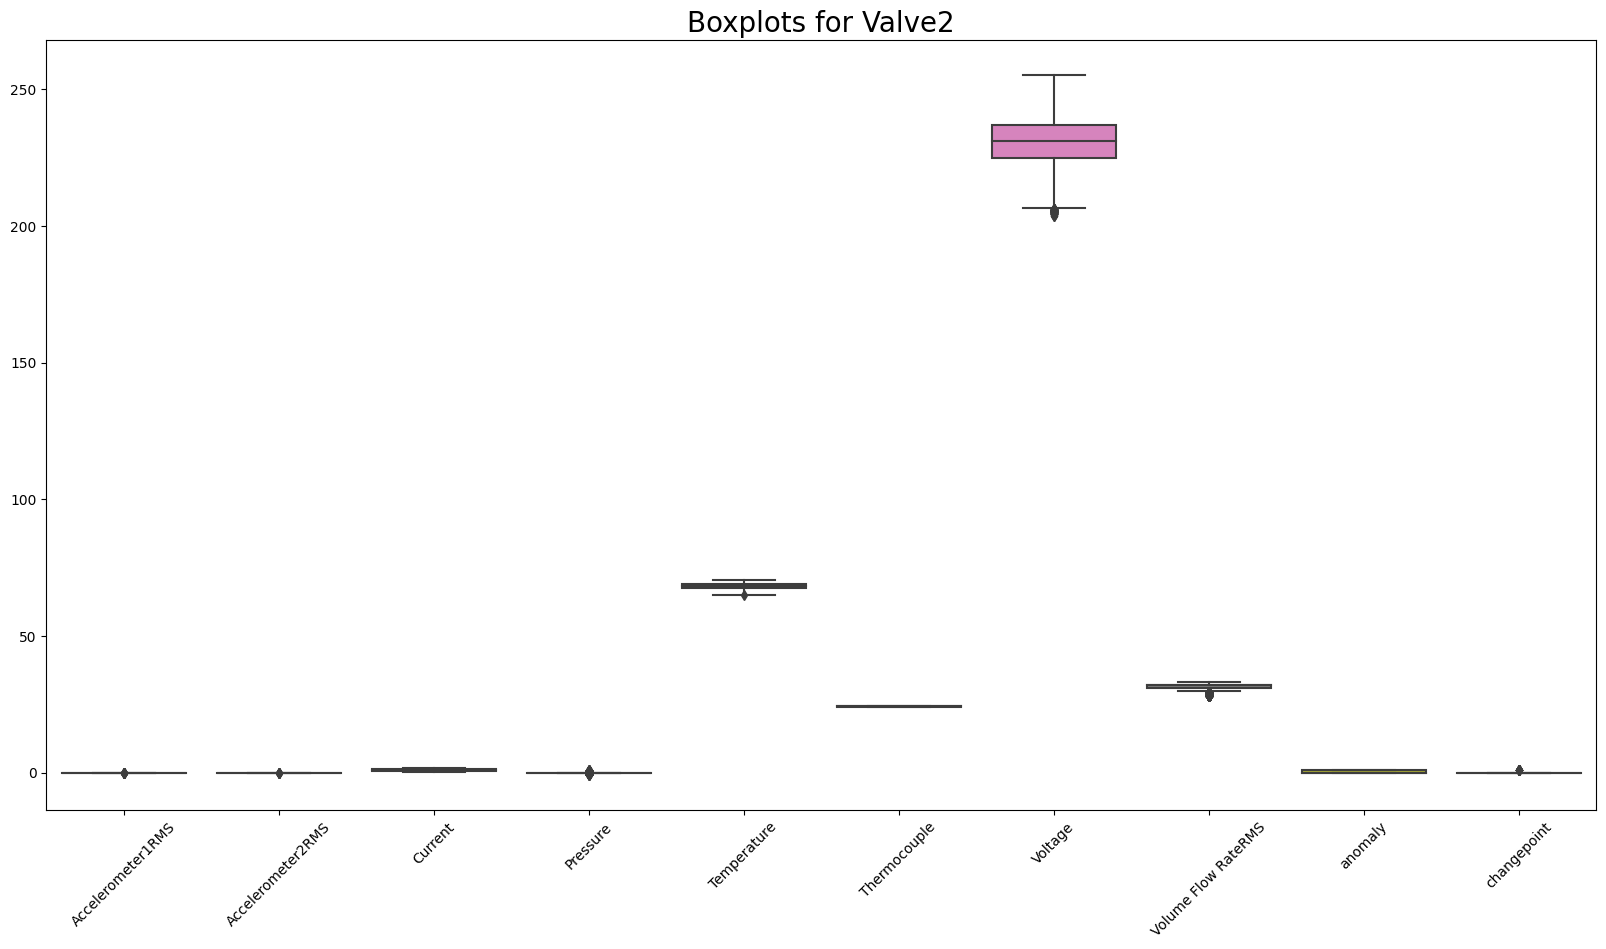

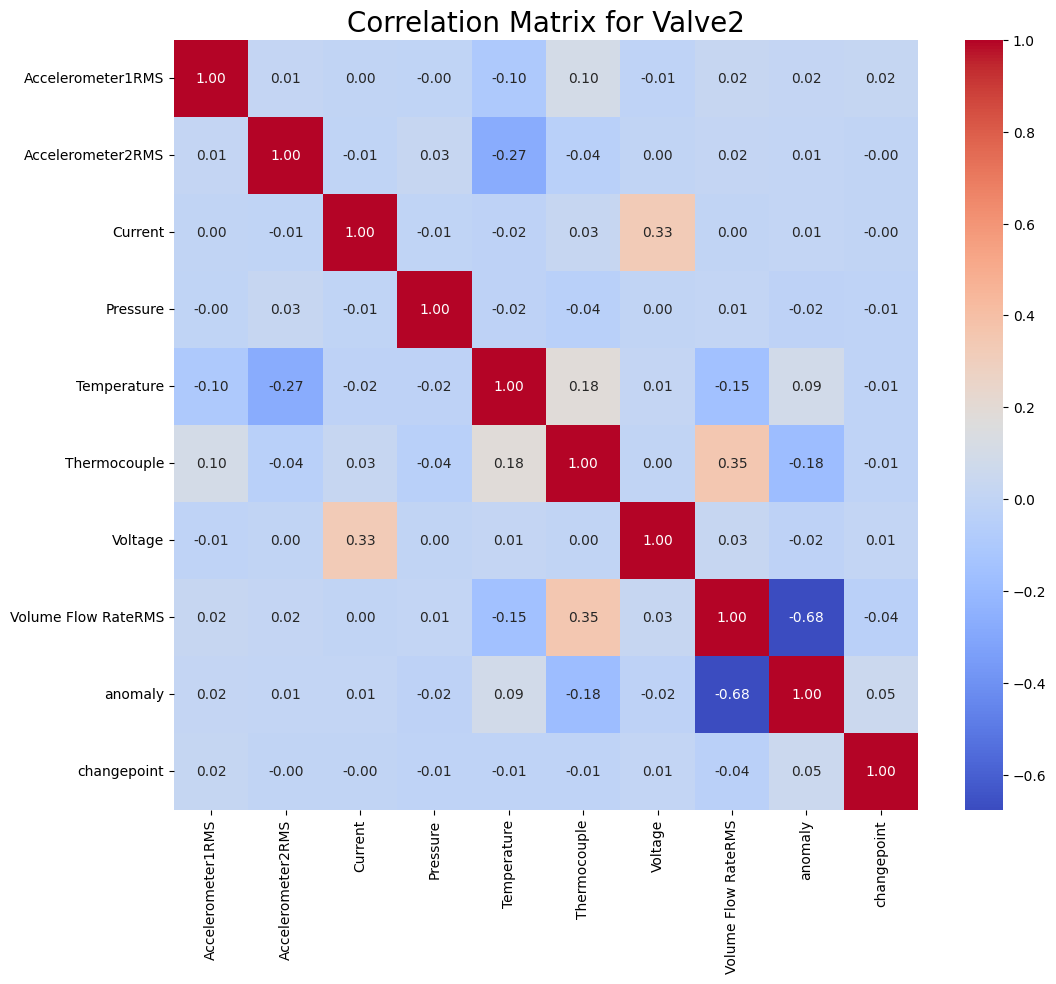

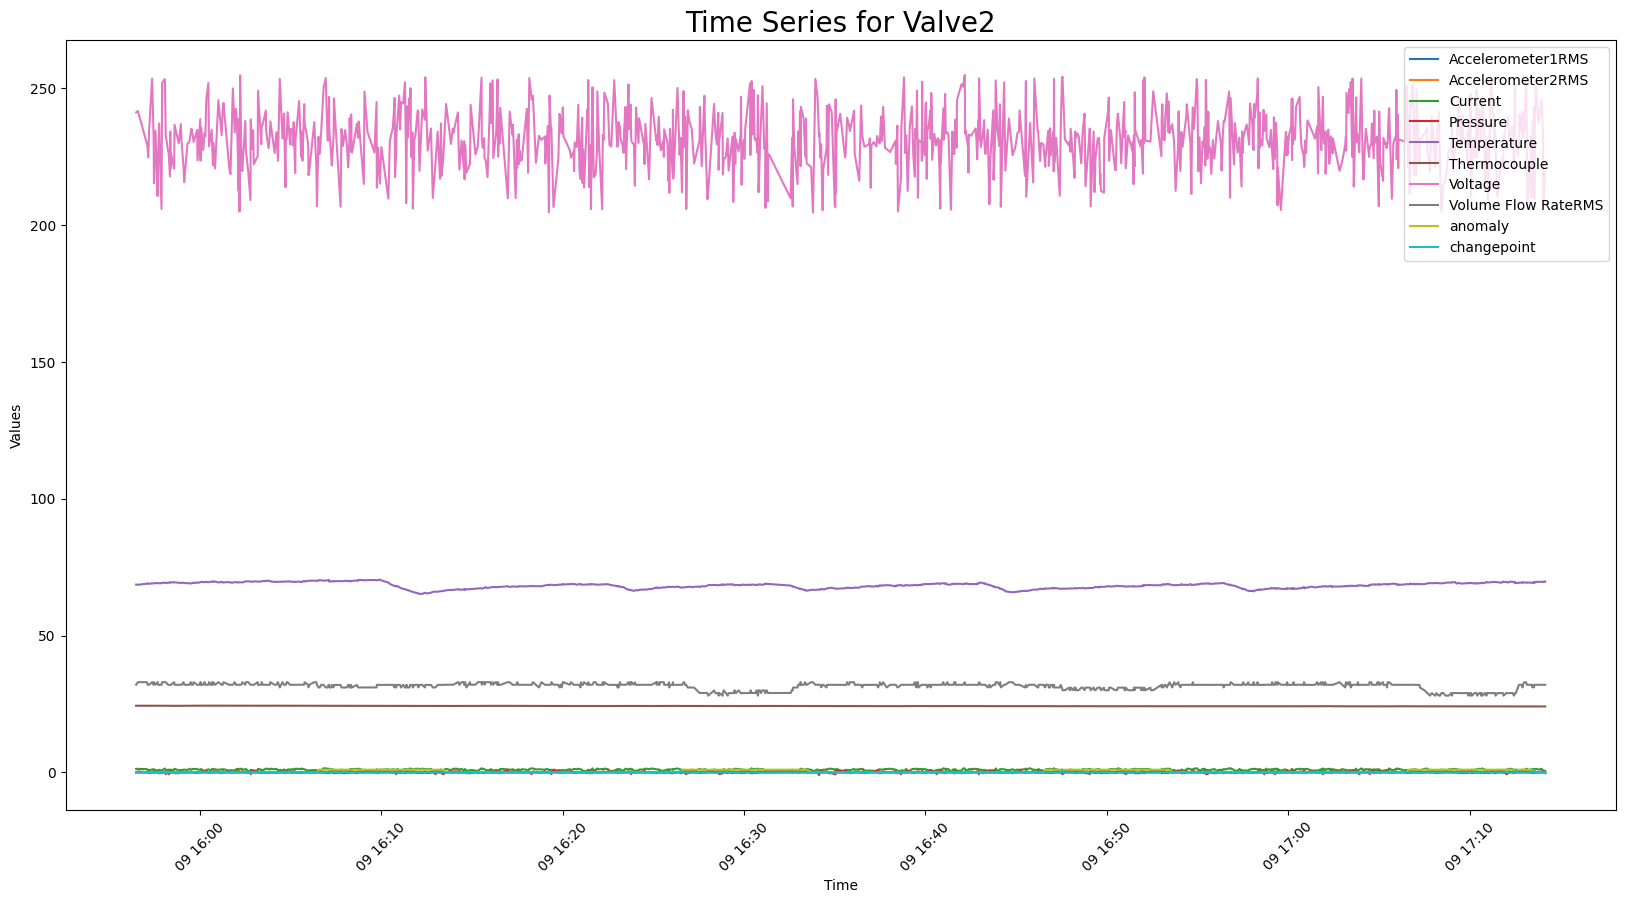

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histograms(df, title):
    df_numeric = df.select_dtypes(include=['float64'])
    df_numeric.hist(bins=30, figsize=(20, 15))
    plt.suptitle(f"Histograms for {title}", fontsize=20)
    plt.show()

def plot_boxplots(df, title):
    df_numeric = df.select_dtypes(include=['float64'])
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=df_numeric)
    plt.title(f"Boxplots for {title}", fontsize=20)
    plt.xticks(rotation=45)
    plt.show()

def plot_correlation_heatmap(df, title):
    df_numeric = df.select_dtypes(include=['float64'])
    corr = df_numeric.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title(f"Correlation Matrix for {title}", fontsize=20)
    plt.show()

def plot_time_series(df, title, sample_size=1000):
    sampled_df = df.sample(n=sample_size) if len(df) > sample_size else df
    sampled_df = sampled_df.sort_values('datetime')
    numeric_columns = sampled_df.select_dtypes(include=['float64']).columns
    
    plt.figure(figsize=(20, 10))
    for col in numeric_columns:
        plt.plot(sampled_df['datetime'], sampled_df[col], label=col)
    plt.title(f"Time Series for {title}", fontsize=20)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.show()

plot_histograms(anomaly_free_df, 'Anomaly-Free')
plot_boxplots(anomaly_free_df, 'Anomaly-Free')
plot_correlation_heatmap(anomaly_free_df, 'Anomaly-Free')
plot_time_series(anomaly_free_df, 'Anomaly-Free')

plot_histograms(valve1_df, 'Valve1')
plot_boxplots(valve1_df, 'Valve1')
plot_correlation_heatmap(valve1_df, 'Valve1')
plot_time_series(valve1_df, 'Valve1')

plot_histograms(valve2_df, 'Valve2')
plot_boxplots(valve2_df, 'Valve2')
plot_correlation_heatmap(valve2_df, 'Valve2')
plot_time_series(valve2_df, 'Valve2')


## LOF

In [4]:
from sklearn.preprocessing import MinMaxScaler

significant_features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Volume Flow RateRMS']

combined_data = anomaly_free_df[significant_features]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(combined_data)

prepared_data = pd.DataFrame(normalized_data, columns=significant_features)

print("Data is prepared and normalized for LOF:")
print(prepared_data.head())


Data is prepared and normalized for LOF:
   Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
0           0.363690           0.850372  0.550851  0.625000   
1           0.383161           0.935215  0.513235  0.375001   
2           0.354968           0.870335  0.700048  0.625000   
3           0.394500           0.942873  0.688167  0.500000   
4           0.350735           0.888320  0.602057  0.750000   

   Volume Flow RateRMS  
0             0.450497  
1             0.419009  
2             0.322419  
3             0.353907  
4             0.386361  


In [6]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, metric='euclidean', contamination=0.1)

lof_predictions = lof.fit_predict(prepared_data)

prepared_data['Anomaly'] = (lof_predictions == -1).astype(int)

print("LOF results added to the dataset:")
print(prepared_data.head())

num_anomalies = prepared_data['Anomaly'].sum()
print(f"Number of anomalies detected: {num_anomalies}")


LOF results added to the dataset:
   Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
0           0.363690           0.850372  0.550851  0.625000   
1           0.383161           0.935215  0.513235  0.375001   
2           0.354968           0.870335  0.700048  0.625000   
3           0.394500           0.942873  0.688167  0.500000   
4           0.350735           0.888320  0.602057  0.750000   

   Volume Flow RateRMS  Anomaly  
0             0.450497        0  
1             0.419009        0  
2             0.322419        0  
3             0.353907        0  
4             0.386361        1  
Number of anomalies detected: 941


In [7]:
from sklearn.metrics import f1_score, precision_score, recall_score

valve1_data = scaler.transform(valve1_df[significant_features])
valve2_data = scaler.transform(valve2_df[significant_features])

valve1_preds = lof.fit_predict(valve1_data)
valve2_preds = lof.fit_predict(valve2_data)

valve1_df['Anomaly_Predicted'] = (valve1_preds == -1).astype(int)
valve2_df['Anomaly_Predicted'] = (valve2_preds == -1).astype(int)

valve1_f1 = f1_score(valve1_df['anomaly'], valve1_df['Anomaly_Predicted'])
valve1_precision = precision_score(valve1_df['anomaly'], valve1_df['Anomaly_Predicted'])
valve1_recall = recall_score(valve1_df['anomaly'], valve1_df['Anomaly_Predicted'])

valve2_f1 = f1_score(valve2_df['anomaly'], valve2_df['Anomaly_Predicted'])
valve2_precision = precision_score(valve2_df['anomaly'], valve2_df['Anomaly_Predicted'])
valve2_recall = recall_score(valve2_df['anomaly'], valve2_df['Anomaly_Predicted'])

print("=== Valve1 Metrics ===")
print(f"F1 Score: {valve1_f1:.3f}")
print(f"Precision: {valve1_precision:.3f}")
print(f"Recall: {valve1_recall:.3f}")

print("\n=== Valve2 Metrics ===")
print(f"F1 Score: {valve2_f1:.3f}")
print(f"Precision: {valve2_precision:.3f}")
print(f"Recall: {valve2_recall:.3f}")

valve1_outlier_ratio = valve1_df['Anomaly_Predicted'].mean()
valve2_outlier_ratio = valve2_df['Anomaly_Predicted'].mean()

print("\n=== Model Evaluation without Labels ===")
print(f"Valve1 Outlier Ratio: {valve1_outlier_ratio:.3f}")
print(f"Valve2 Outlier Ratio: {valve2_outlier_ratio:.3f}")


=== Valve1 Metrics ===
F1 Score: 0.179
Precision: 0.401
Recall: 0.115

=== Valve2 Metrics ===
F1 Score: 0.193
Precision: 0.435
Recall: 0.124

=== Model Evaluation without Labels ===
Valve1 Outlier Ratio: 0.100
Valve2 Outlier Ratio: 0.100


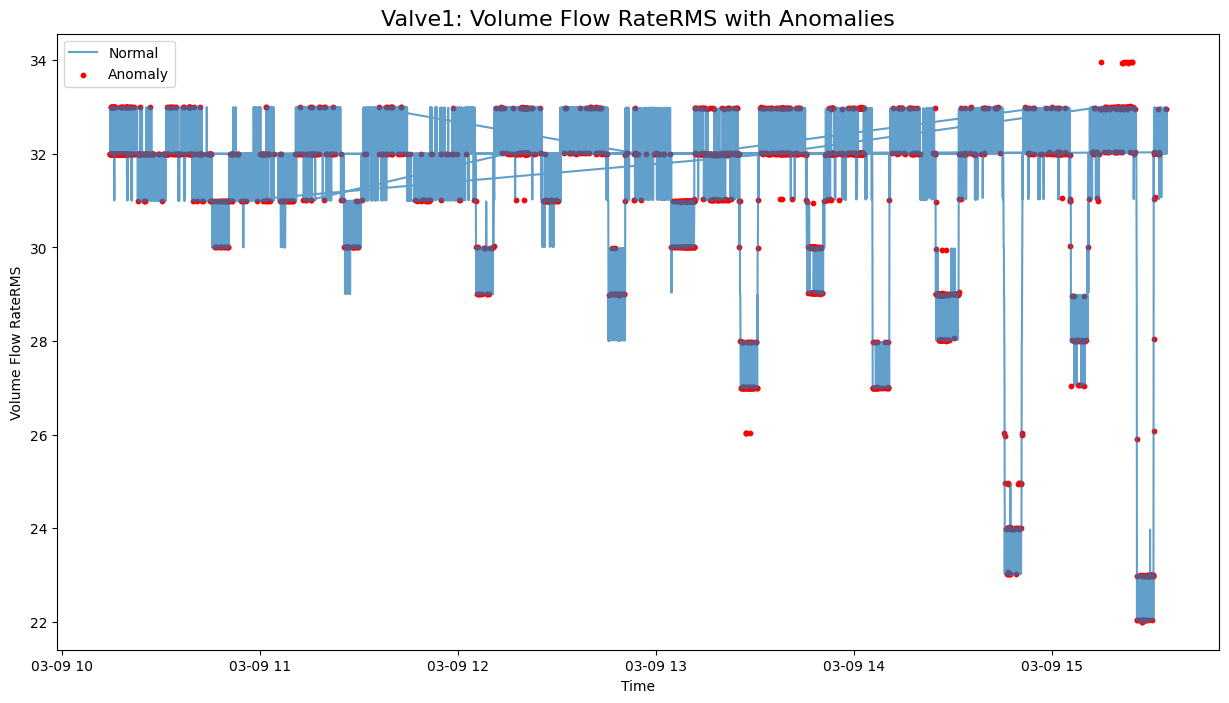

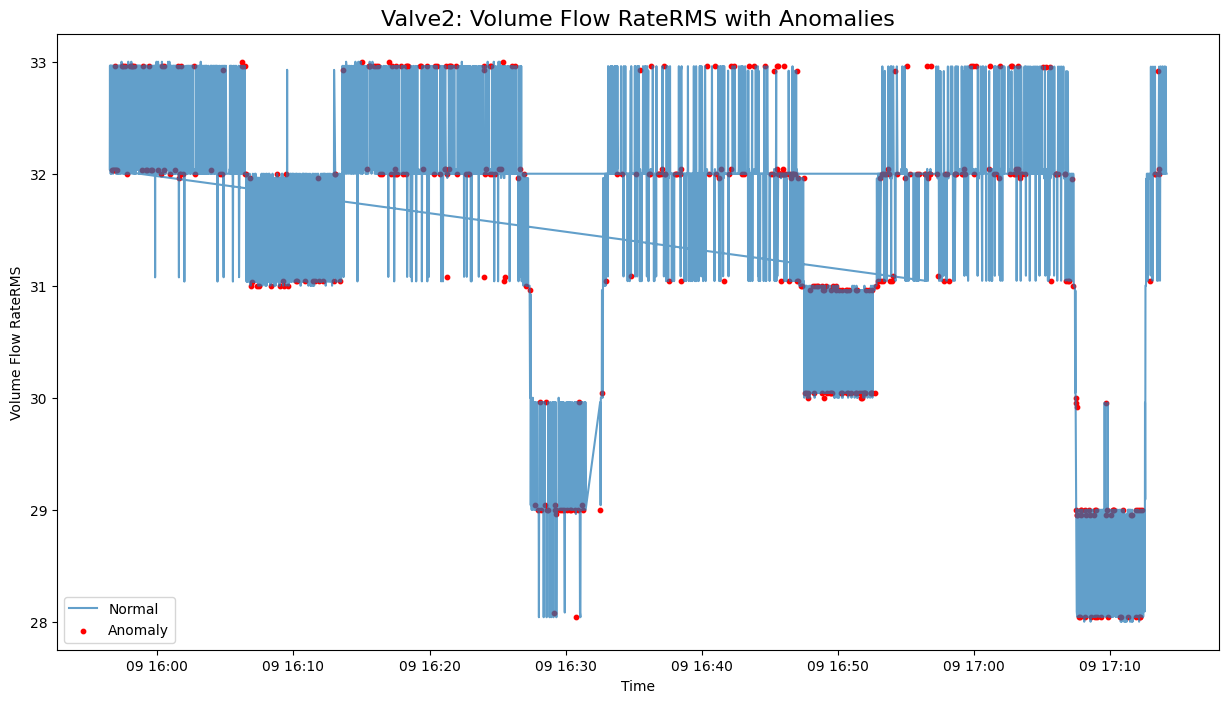

In [8]:
def plot_time_series_with_anomalies(data, feature, title):
    plt.figure(figsize=(15, 8))
    normal_data = data[data['Anomaly_Predicted'] == 0]
    anomaly_data = data[data['Anomaly_Predicted'] == 1]

    plt.plot(normal_data['datetime'], normal_data[feature], label='Normal', alpha=0.7)

    plt.scatter(anomaly_data['datetime'], anomaly_data[feature], color='red', label='Anomaly', s=10)

    plt.title(f"{title} with Anomalies", fontsize=16)
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

plot_time_series_with_anomalies(valve1_df, 'Volume Flow RateRMS', 'Valve1: Volume Flow RateRMS')
plot_time_series_with_anomalies(valve2_df, 'Volume Flow RateRMS', 'Valve2: Volume Flow RateRMS')


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import make_scorer, f1_score

def lof_scorer(estimator, X):
    predictions = estimator.fit_predict(X)
    predictions = (predictions == -1).astype(int)
    return f1_score(y_true, predictions)

f1_scorer = make_scorer(lof_scorer, greater_is_better=True)

param_grid = {
    'n_neighbors': [10, 20, 30, 50],
    'contamination': [0.05, 0.1, 0.15]
}

grid_search = GridSearchCV(
    estimator=LocalOutlierFactor(metric='euclidean', novelty=False),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=3,
    verbose=1
)

grid_search.fit(prepared_data[significant_features], prepared_data['Anomaly'])

best_lof_params = grid_search.best_params_
print("Best LOF parameters:", best_lof_params)

optimized_lof = LocalOutlierFactor(
    n_neighbors=best_lof_params['n_neighbors'],
    contamination=best_lof_params['contamination'],
    metric='euclidean'
)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 86, in 

Best LOF parameters: {'contamination': 0.05, 'n_neighbors': 10}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 86, in 

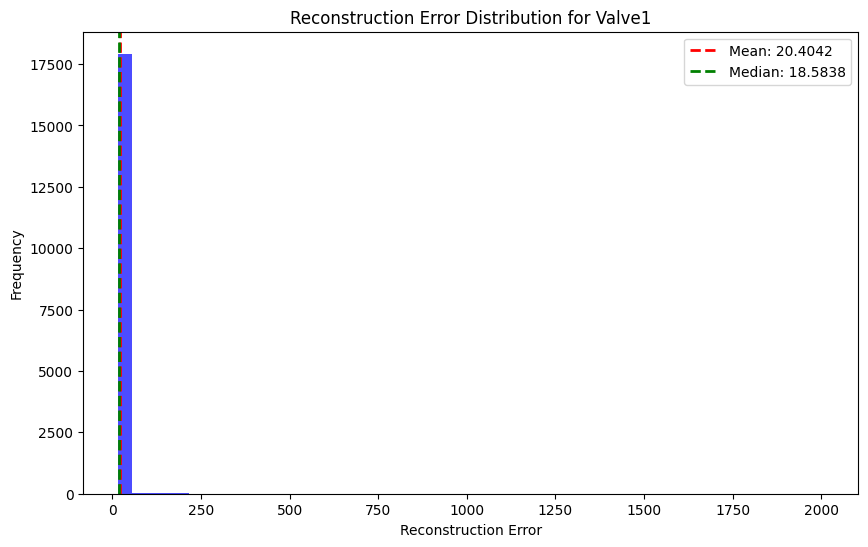

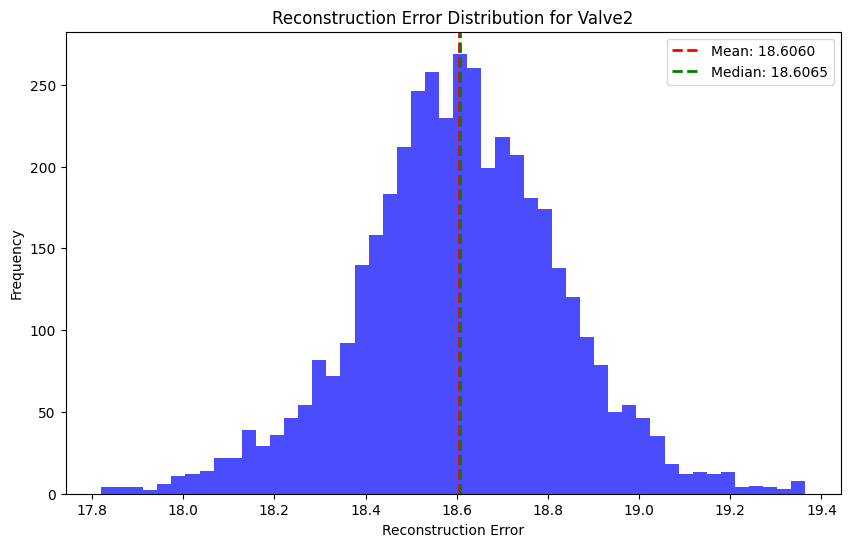

=== Valve1 Quality Metrics (without labels) ===
{'Outlier Ratio': 0.050044336067390824, 'Mean Error': 20.404174030770434, 'Median Error': 18.583796398800974, 'Error Std': 34.12524532087253}
=== Valve2 Quality Metrics (without labels) ===
{'Outlier Ratio': 0.032411820781696854, 'Mean Error': 18.605978911434544, 'Median Error': 18.606538266120992, 'Error Std': 0.223853009104019}


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

def calculate_outlier_ratio(anomaly_predictions):
    ratio = np.mean(anomaly_predictions)
    return ratio

def plot_error_distribution(errors, title):
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, color='blue', alpha=0.7)
    plt.axvline(np.mean(errors), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(errors):.4f}')
    plt.axvline(np.median(errors), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(errors):.4f}')
    plt.title(title)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def evaluate_quality_without_labels(errors, anomaly_predictions):
    outlier_ratio = calculate_outlier_ratio(anomaly_predictions)
    mean_error = np.mean(errors)
    median_error = np.median(errors)
    std_error = np.std(errors)
    
    quality_metrics = {
        "Outlier Ratio": outlier_ratio,
        "Mean Error": mean_error,
        "Median Error": median_error,
        "Error Std": std_error,
    }
    
    return quality_metrics

valve1_quality_metrics = evaluate_quality_without_labels(valve1_errors, valve1_anomalies)
valve2_quality_metrics = evaluate_quality_without_labels(valve2_errors, valve2_anomalies)

plot_error_distribution(valve1_errors, "Reconstruction Error Distribution for Valve1")
plot_error_distribution(valve2_errors, "Reconstruction Error Distribution for Valve2")

print("=== Valve1 Quality Metrics (without labels) ===")
print(valve1_quality_metrics)

print("=== Valve2 Quality Metrics (without labels) ===")
print(valve2_quality_metrics)

In [10]:
optimized_lof = LocalOutlierFactor(
    n_neighbors=10,
    contamination=0.05,
    metric='euclidean'
)

additional_features = ['Temperature', 'Thermocouple']
all_features = significant_features + additional_features

combined_data_with_additional = anomaly_free_df[all_features]
normalized_additional_data = scaler.fit_transform(combined_data_with_additional)

prepared_data_with_additional = pd.DataFrame(normalized_additional_data, columns=all_features)

lof_predictions_with_additional = optimized_lof.fit_predict(prepared_data_with_additional)
prepared_data_with_additional['Anomaly'] = (lof_predictions_with_additional == -1).astype(int)

print("Updated data with additional features and LOF results:")
print(prepared_data_with_additional.head())

num_anomalies_with_additional = prepared_data_with_additional['Anomaly'].sum()
print(f"Number of anomalies detected with additional features: {num_anomalies_with_additional}")


Updated data with additional features and LOF results:
   Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
0           0.363690           0.850372  0.550851  0.625000   
1           0.383161           0.935215  0.513235  0.375001   
2           0.354968           0.870335  0.700048  0.625000   
3           0.394500           0.942873  0.688167  0.500000   
4           0.350735           0.888320  0.602057  0.750000   

   Volume Flow RateRMS  Temperature  Thermocouple  Anomaly  
0             0.450497     0.696224      0.000000        0  
1             0.419009     0.739110      0.004904        0  
2             0.322419     0.732131      0.003556        0  
3             0.353907     0.751660      0.004043        0  
4             0.386361     0.702133      0.003556        0  
Number of anomalies detected with additional features: 471


In [11]:
additional_features = ['Temperature', 'Thermocouple']
all_features = significant_features + additional_features

combined_data_with_additional = anomaly_free_df[all_features]
normalized_additional_data = scaler.fit_transform(combined_data_with_additional)

prepared_data_with_additional = pd.DataFrame(normalized_additional_data, columns=all_features)

optimized_lof.fit(prepared_data_with_additional)
lof_predictions_with_additional = optimized_lof.fit_predict(prepared_data_with_additional)
prepared_data_with_additional['Anomaly'] = (lof_predictions_with_additional == -1).astype(int)

print("Updated data with additional features and LOF results:")
print(prepared_data_with_additional.head())


Updated data with additional features and LOF results:
   Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
0           0.363690           0.850372  0.550851  0.625000   
1           0.383161           0.935215  0.513235  0.375001   
2           0.354968           0.870335  0.700048  0.625000   
3           0.394500           0.942873  0.688167  0.500000   
4           0.350735           0.888320  0.602057  0.750000   

   Volume Flow RateRMS  Temperature  Thermocouple  Anomaly  
0             0.450497     0.696224      0.000000        0  
1             0.419009     0.739110      0.004904        0  
2             0.322419     0.732131      0.003556        0  
3             0.353907     0.751660      0.004043        0  
4             0.386361     0.702133      0.003556        0  


произошло снижение количества аномалий, что является ожидаемым результатом

## Isolation Forest

In [13]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)


iso_forest.fit(prepared_data[significant_features])

valve1_iso_preds = iso_forest.predict(valve1_df[significant_features])
valve2_iso_preds = iso_forest.predict(valve2_df[significant_features])

valve1_df['Anomaly_Predicted_IF'] = (valve1_iso_preds == -1).astype(int)
valve2_df['Anomaly_Predicted_IF'] = (valve2_iso_preds == -1).astype(int)

valve1_f1_if = f1_score(valve1_df['anomaly'], valve1_df['Anomaly_Predicted_IF'])
valve1_precision_if = precision_score(valve1_df['anomaly'], valve1_df['Anomaly_Predicted_IF'])
valve1_recall_if = recall_score(valve1_df['anomaly'], valve1_df['Anomaly_Predicted_IF'])

valve2_f1_if = f1_score(valve2_df['anomaly'], valve2_df['Anomaly_Predicted_IF'])
valve2_precision_if = precision_score(valve2_df['anomaly'], valve2_df['Anomaly_Predicted_IF'])
valve2_recall_if = recall_score(valve2_df['anomaly'], valve2_df['Anomaly_Predicted_IF'])

print("=== Valve1 Metrics with Isolation Forest ===")
print(f"F1 Score: {valve1_f1_if:.3f}")
print(f"Precision: {valve1_precision_if:.3f}")
print(f"Recall: {valve1_recall_if:.3f}")

print("\n=== Valve2 Metrics with Isolation Forest ===")
print(f"F1 Score: {valve2_f1_if:.3f}")
print(f"Precision: {valve2_precision_if:.3f}")
print(f"Recall: {valve2_recall_if:.3f}")




=== Valve1 Metrics with Isolation Forest ===
F1 Score: 0.516
Precision: 0.347
Recall: 1.000

=== Valve2 Metrics with Isolation Forest ===
F1 Score: 0.521
Precision: 0.352
Recall: 1.000


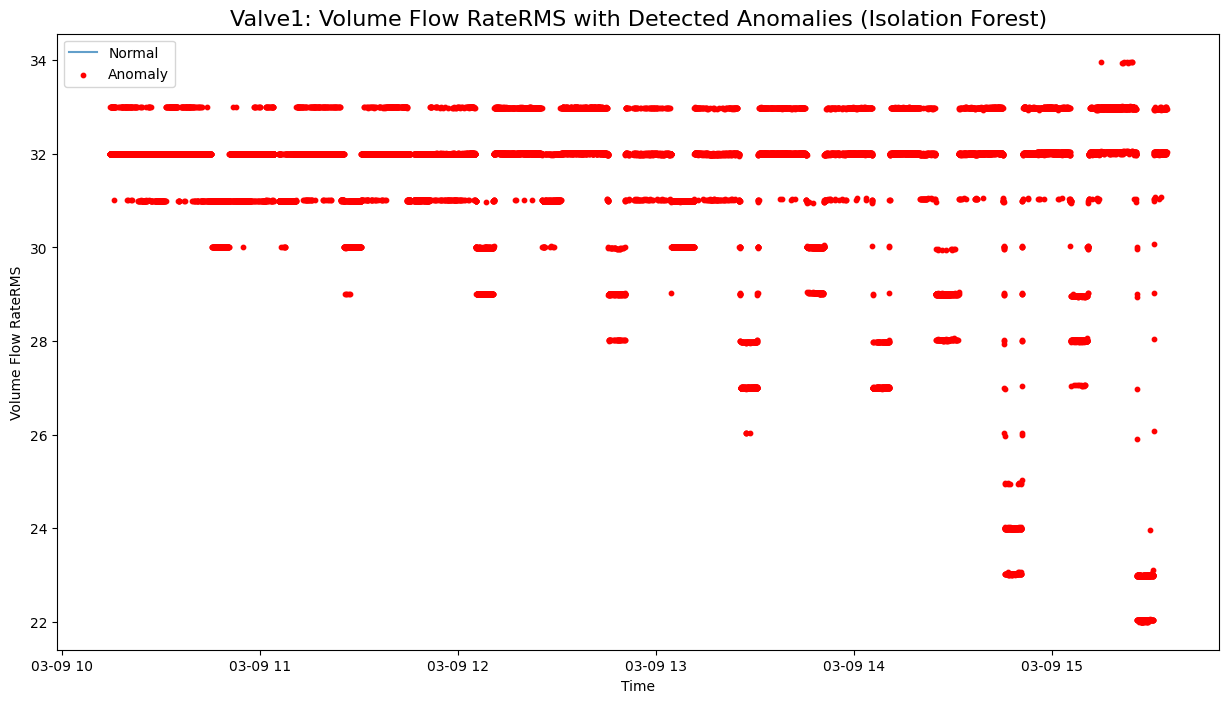

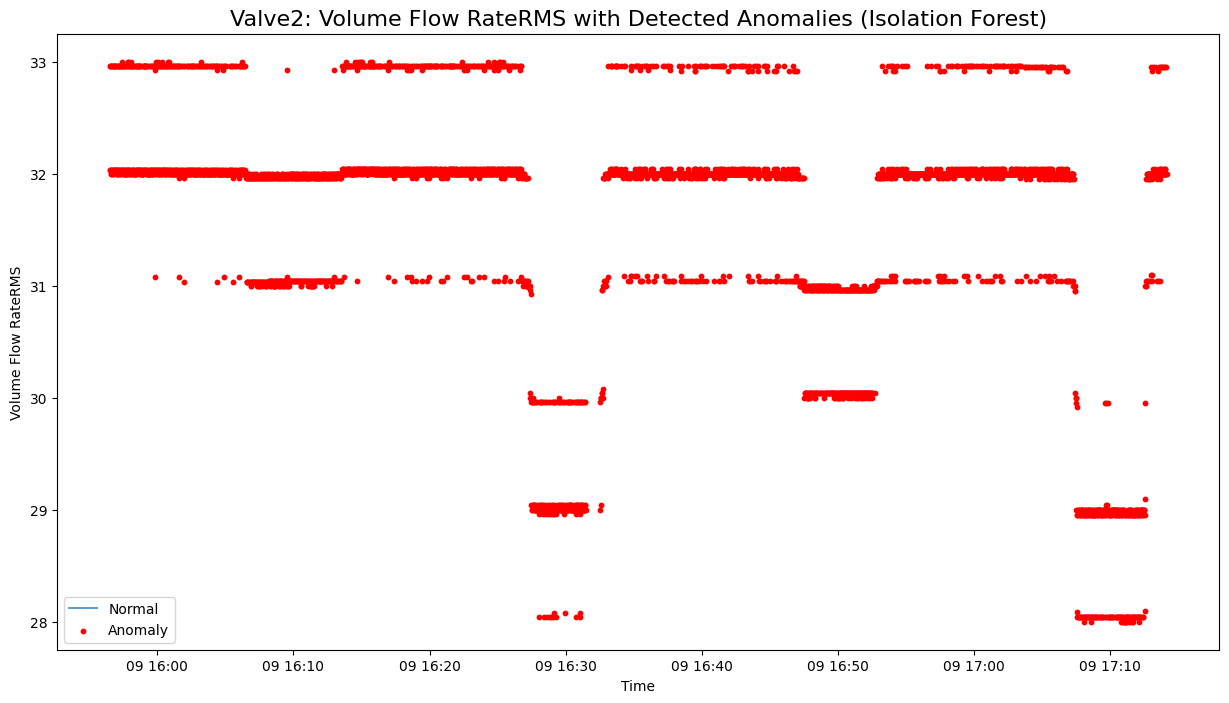

In [14]:
def plot_time_series_anomalies_if(data, feature, title):
    plt.figure(figsize=(15, 8))
    normal_data = data[data['Anomaly_Predicted_IF'] == 0]
    anomaly_data = data[data['Anomaly_Predicted_IF'] == 1]

    plt.plot(normal_data['datetime'], normal_data[feature], label='Normal', alpha=0.7)

    plt.scatter(anomaly_data['datetime'], anomaly_data[feature], color='red', label='Anomaly', s=10)

    plt.title(f"{title} with Detected Anomalies (Isolation Forest)", fontsize=16)
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

plot_time_series_anomalies_if(valve1_df, 'Volume Flow RateRMS', 'Valve1: Volume Flow RateRMS')
plot_time_series_anomalies_if(valve2_df, 'Volume Flow RateRMS', 'Valve2: Volume Flow RateRMS')


наблюдаем переобучение

## A bit of One Class SVM :) 

In [15]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(
    kernel='rbf',  
    nu=0.05,       
    gamma='scale'  
)

one_class_svm.fit(prepared_data[significant_features])

valve1_svm_preds = one_class_svm.predict(valve1_df[significant_features])
valve2_svm_preds = one_class_svm.predict(valve2_df[significant_features])

valve1_df['Anomaly_Predicted_SVM'] = (valve1_svm_preds == -1).astype(int)
valve2_df['Anomaly_Predicted_SVM'] = (valve2_svm_preds == -1).astype(int)

valve1_f1_svm = f1_score(valve1_df['anomaly'], valve1_df['Anomaly_Predicted_SVM'])
valve1_precision_svm = precision_score(valve1_df['anomaly'], valve1_df['Anomaly_Predicted_SVM'])
valve1_recall_svm = recall_score(valve1_df['anomaly'], valve1_df['Anomaly_Predicted_SVM'])

valve2_f1_svm = f1_score(valve2_df['anomaly'], valve2_df['Anomaly_Predicted_SVM'])
valve2_precision_svm = precision_score(valve2_df['anomaly'], valve2_df['Anomaly_Predicted_SVM'])
valve2_recall_svm = recall_score(valve2_df['anomaly'], valve2_df['Anomaly_Predicted_SVM'])

print("=== Valve1 Metrics with One-Class SVM ===")
print(f"F1 Score: {valve1_f1_svm:.3f}")
print(f"Precision: {valve1_precision_svm:.3f}")
print(f"Recall: {valve1_recall_svm:.3f}")

print("\n=== Valve2 Metrics with One-Class SVM ===")
print(f"F1 Score: {valve2_f1_svm:.3f}")
print(f"Precision: {valve2_precision_svm:.3f}")
print(f"Recall: {valve2_recall_svm:.3f}")


=== Valve1 Metrics with One-Class SVM ===
F1 Score: 0.516
Precision: 0.347
Recall: 1.000

=== Valve2 Metrics with One-Class SVM ===
F1 Score: 0.521
Precision: 0.352
Recall: 1.000


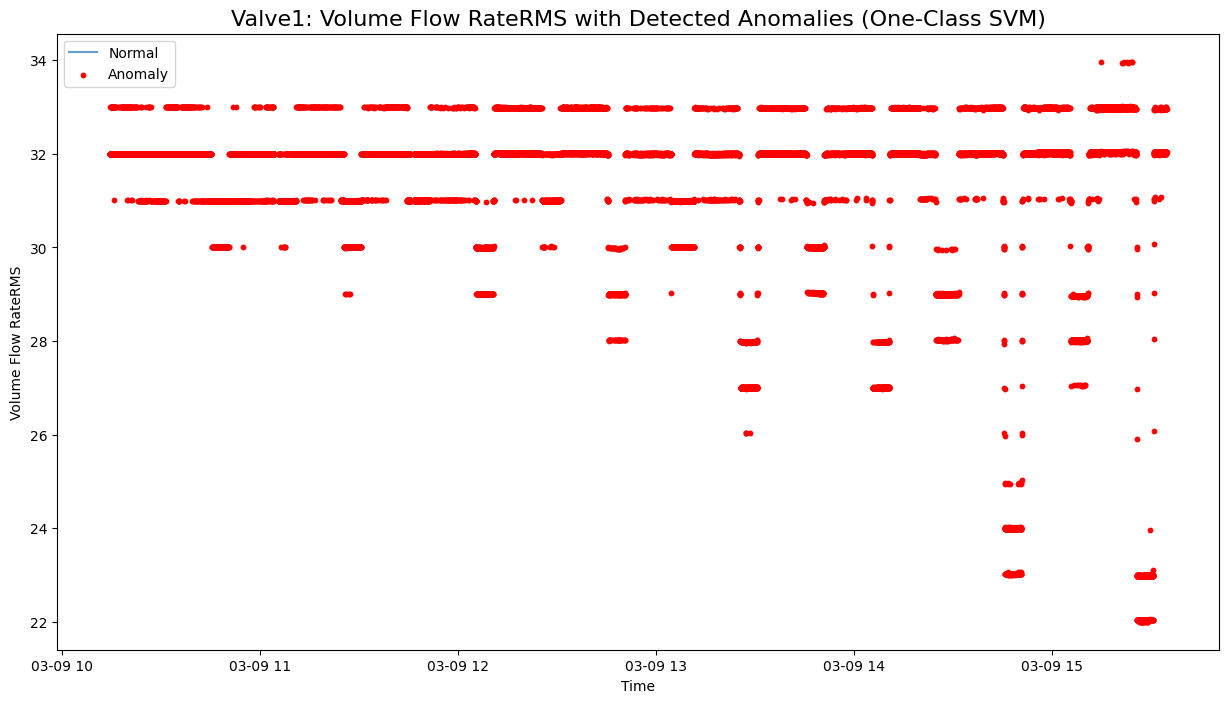

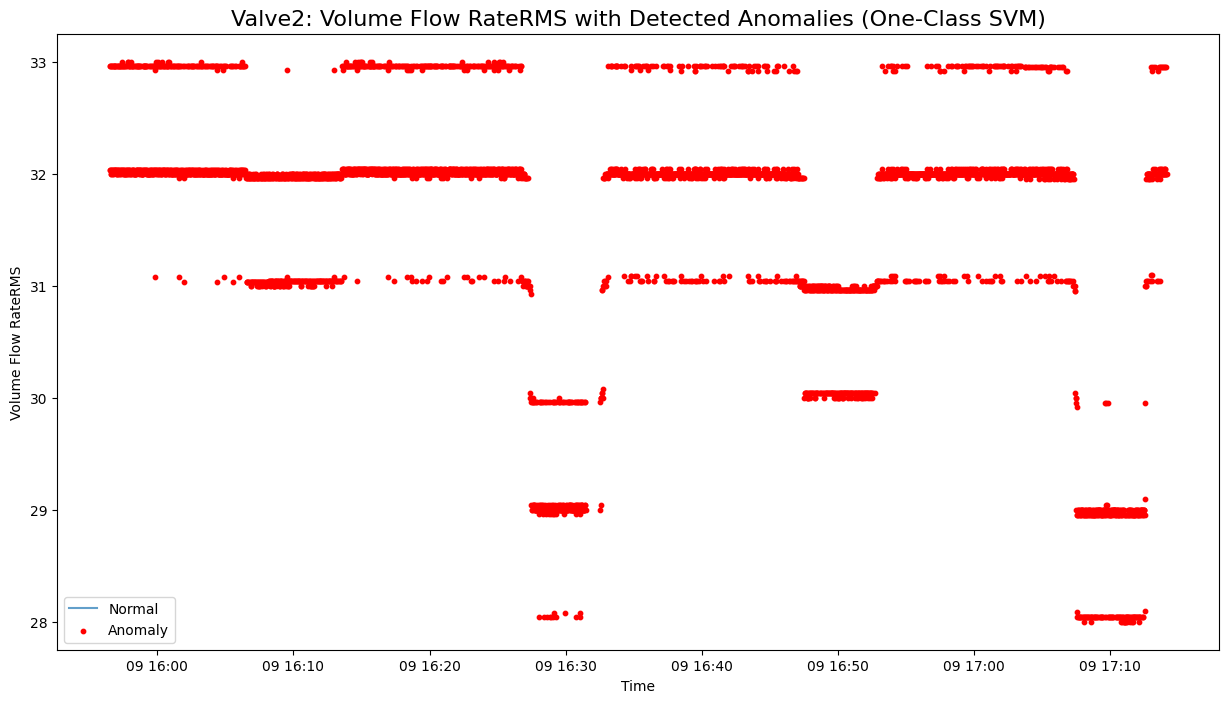

In [16]:
# Визуализация временных рядов с аномалиями (One-Class SVM)
def plot_time_series_anomalies_svm(data, feature, title):
    plt.figure(figsize=(15, 8))
    normal_data = data[data['Anomaly_Predicted_SVM'] == 0]
    anomaly_data = data[data['Anomaly_Predicted_SVM'] == 1]

    # График нормальных данных
    plt.plot(normal_data['datetime'], normal_data[feature], label='Normal', alpha=0.7)

    # Точки аномалий
    plt.scatter(anomaly_data['datetime'], anomaly_data[feature], color='red', label='Anomaly', s=10)

    plt.title(f"{title} with Detected Anomalies (One-Class SVM)", fontsize=16)
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

# Визуализация для valve1 и valve2
plot_time_series_anomalies_svm(valve1_df, 'Volume Flow RateRMS', 'Valve1: Volume Flow RateRMS')
plot_time_series_anomalies_svm(valve2_df, 'Volume Flow RateRMS', 'Valve2: Volume Flow RateRMS')


наблюдаем переобучение

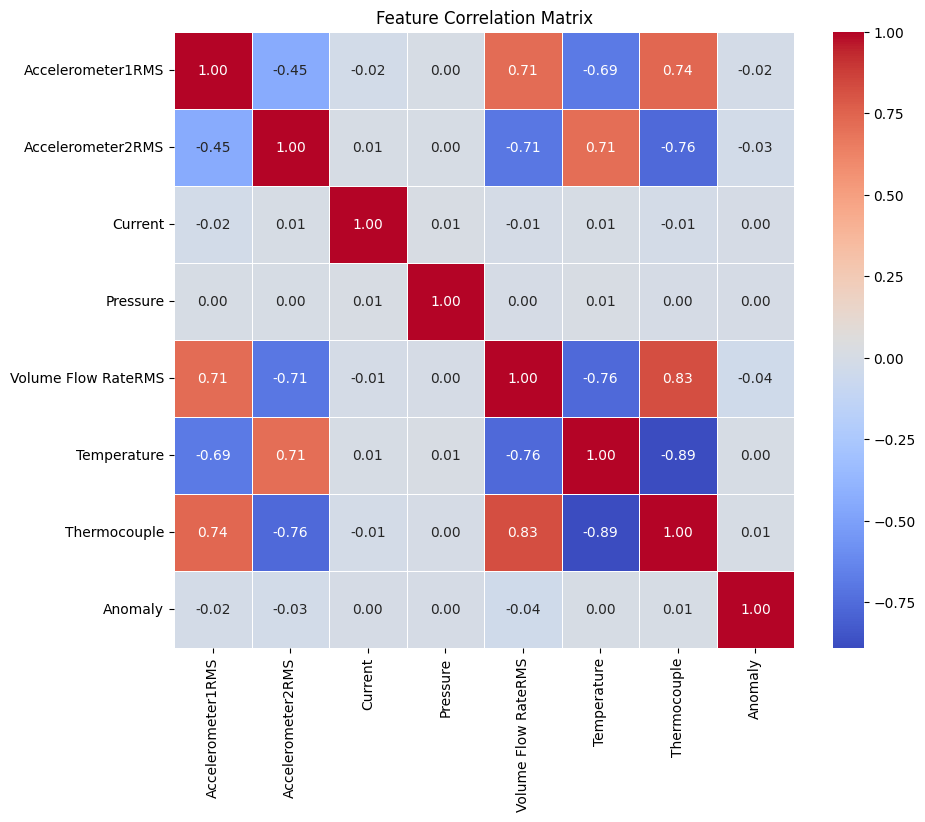

Highly correlated features:
                     Accelerometer1RMS  Accelerometer2RMS  Current  Pressure  \
Accelerometer1RMS                  1.0                NaN      NaN       NaN   
Accelerometer2RMS                  NaN                1.0      NaN       NaN   
Current                            NaN                NaN      1.0       NaN   
Pressure                           NaN                NaN      NaN       1.0   
Volume Flow RateRMS                NaN                NaN      NaN       NaN   
Temperature                        NaN                NaN      NaN       NaN   
Thermocouple                       NaN                NaN      NaN       NaN   
Anomaly                            NaN                NaN      NaN       NaN   

                     Volume Flow RateRMS  Temperature  Thermocouple  Anomaly  
Accelerometer1RMS                    NaN          NaN           NaN      NaN  
Accelerometer2RMS                    NaN          NaN           NaN      NaN  
Current       

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

correlation_matrix = prepared_data_with_additional.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

high_corr_pairs = correlation_matrix[(correlation_matrix > 0.8) | (correlation_matrix < -0.8)]
print("Highly correlated features:")
print(high_corr_pairs)

In [18]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
import numpy as np

def evaluate_model_with_cv(model, X, y, cv_splits=5):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    f1_scores = []
    precision_scores = []
    recall_scores = []

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train)

        y_pred = model.predict(X_val)
        y_pred = np.where(y_pred == -1, 1, 0)  # Аномалии = 1, остальное = 0

        f1_scores.append(f1_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))

    return {
        "F1": np.mean(f1_scores),
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores),
    }

X = prepared_data_with_additional[significant_features].values
y = prepared_data_with_additional['Anomaly'].values

iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_metrics = evaluate_model_with_cv(iso_forest, X, y)
print("Isolation Forest Metrics with Cross-Validation:", iso_metrics)

one_class_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
svm_metrics = evaluate_model_with_cv(one_class_svm, X, y)
print("One-Class SVM Metrics with Cross-Validation:", svm_metrics)

Isolation Forest Metrics with Cross-Validation: {'F1': 0.19470159948086535, 'Precision': 0.1970042626926474, 'Recall': 0.19325867861142215}
One-Class SVM Metrics with Cross-Validation: {'F1': 0.2801748199691927, 'Precision': 0.2746775310216448, 'Recall': 0.28660694288913774}


In [27]:
def evaluate_svm_without_labels(model, X):
    model.fit(X)
    anomaly_predictions = model.predict(X)
    anomaly_predictions = np.where(anomaly_predictions == -1, 1, 0)  # Аномалии = 1, остальное = 0
    outlier_ratio = calculate_outlier_ratio(anomaly_predictions)
    return {"Outlier Ratio": outlier_ratio}

# Оценка качества SVM без использования меток
svm_without_labels_metrics = evaluate_svm_without_labels(one_class_svm, X)
print("One-Class SVM Quality Metrics (without labels):", svm_without_labels_metrics)

One-Class SVM Quality Metrics (without labels): {'Outlier Ratio': 0.05007974481658692}


### LSTM

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
anomaly_free_scaled = scaler.fit_transform(anomaly_free_df[significant_features])

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

seq_length = 30  
train_sequences = create_sequences(anomaly_free_scaled, seq_length)

input_dim = train_sequences.shape[2]
inputs = Input(shape=(seq_length, input_dim))
encoded = LSTM(64, activation="relu", return_sequences=False)(inputs)
latent = RepeatVector(seq_length)(encoded)
decoded = LSTM(64, activation="relu", return_sequences=True)(latent)
outputs = TimeDistributed(Dense(input_dim))(decoded)

model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse")
model.summary()

# Обучение модели
history = model.fit(
    train_sequences,
    train_sequences,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    verbose=1,
)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                17920     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 30, 64)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 30, 64)            33024     
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 5)             325       
 stributed)                                                      
                                                                 
Total params: 51269 (200.27 KB)
Trainable params: 51269 (20

9/9 [==============================] - 0s 13ms/step
Anomaly threshold: 19.01458424814644
=== Valve1 Metrics with LSTM-AE ===
{'F1': 0.20909595119245702, 'Precision': 0.8349944629014396, 'Recall': 0.1195118085275004}
=== Valve2 Metrics with LSTM-AE ===
{'F1': 0.102843315184513, 'Precision': 0.625, 'Recall': 0.05603164139749506}


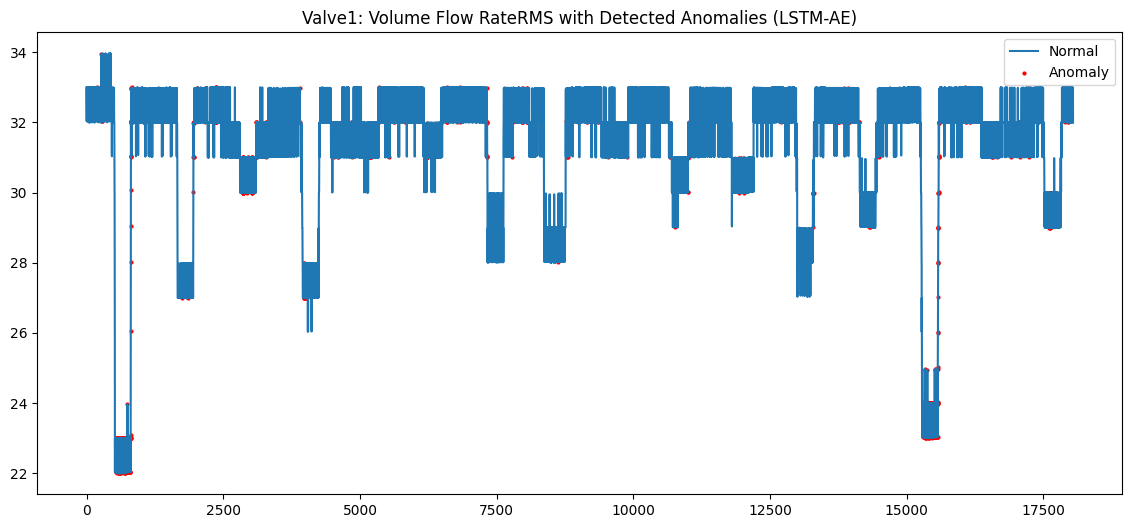

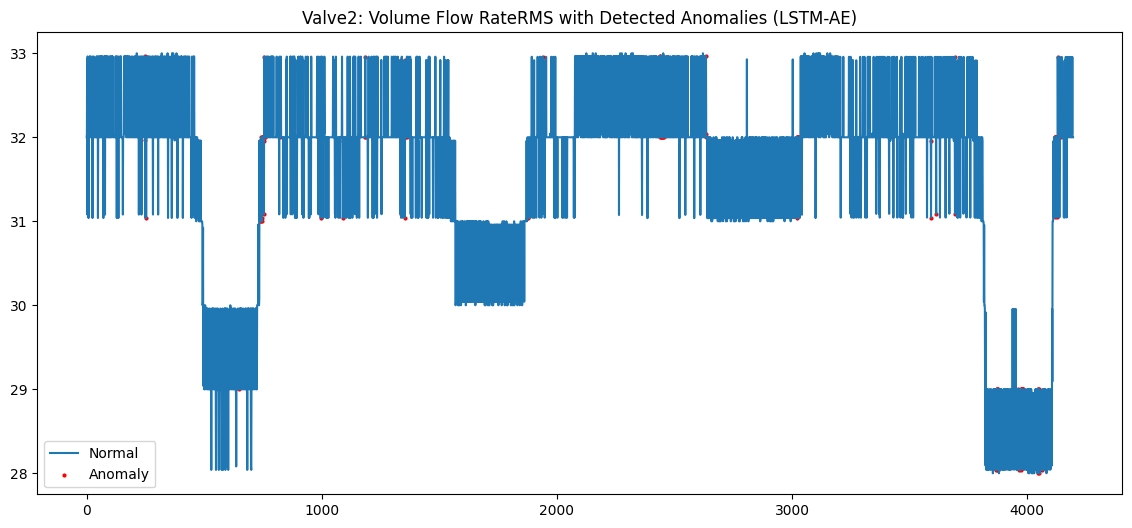

In [25]:
def create_sequences(data, seq_length):
    shape = (data.shape[0] - seq_length + 1, seq_length, data.shape[1])
    strides = (data.strides[0], data.strides[0], data.strides[1])
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

def calculate_reconstruction_error(data, model):
    sequences = create_sequences(data, seq_length)
    predictions = model.predict(sequences, batch_size=512)
    mse = np.mean(np.square(sequences - predictions), axis=(1, 2))
    return mse

def calculate_metrics(true_labels, predicted_anomalies):
    tp = np.sum((true_labels == 1) & (predicted_anomalies == 1))
    fp = np.sum((true_labels == 0) & (predicted_anomalies == 1))
    fn = np.sum((true_labels == 1) & (predicted_anomalies == 0))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return {"F1": f1, "Precision": precision, "Recall": recall}

def plot_anomalies(time_series, anomalies, title):
    plt.figure(figsize=(14, 6))
    plt.plot(time_series, label="Normal")
    plt.scatter(np.where(anomalies)[0], time_series[anomalies == 1], color="red", label="Anomaly", s=4)
    plt.title(title)
    plt.legend()
    plt.show()

valve1_scaled = scaler.transform(valve1_df[significant_features])
valve2_scaled = scaler.transform(valve2_df[significant_features])

valve1_errors = calculate_reconstruction_error(valve1_scaled, model)
valve2_errors = calculate_reconstruction_error(valve2_scaled, model)

threshold = np.percentile(valve1_errors, 95)
print(f"Anomaly threshold: {threshold}")

valve1_anomalies = (valve1_errors > threshold).astype(int)
valve2_anomalies = (valve2_errors > threshold).astype(int)

valve1_df = valve1_df.iloc[seq_length - 1 :].reset_index(drop=True)
valve2_df = valve2_df.iloc[seq_length - 1 :].reset_index(drop=True)

valve1_df["DetectedAnomaly"] = valve1_anomalies
valve2_df["DetectedAnomaly"] = valve2_anomalies

valve1_metrics = calculate_metrics(valve1_df["anomaly"].values, valve1_df["DetectedAnomaly"].values)
valve2_metrics = calculate_metrics(valve2_df["anomaly"].values, valve2_df["DetectedAnomaly"].values)

print("=== Valve1 Metrics with LSTM-AE ===")
print(valve1_metrics)
print("=== Valve2 Metrics with LSTM-AE ===")
print(valve2_metrics)

plot_anomalies(valve1_df["Volume Flow RateRMS"].values, valve1_df["DetectedAnomaly"].values, "Valve1: Volume Flow RateRMS with Detected Anomalies (LSTM-AE)")
plot_anomalies(valve2_df["Volume Flow RateRMS"].values, valve2_df["DetectedAnomaly"].values, "Valve2: Volume Flow RateRMS with Detected Anomalies (LSTM-AE)")


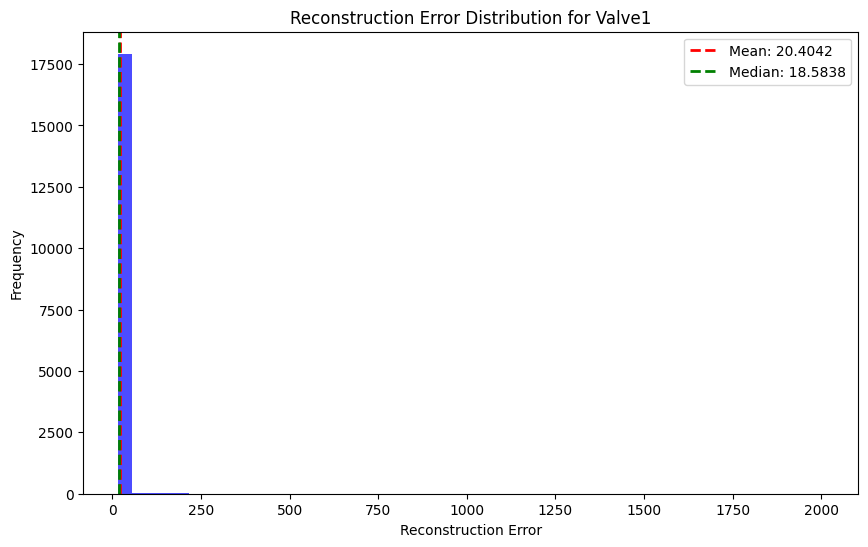

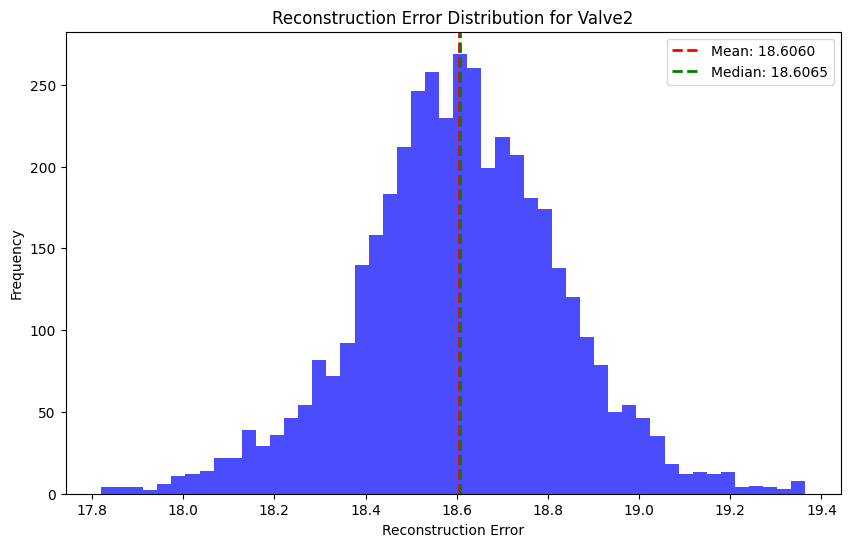

=== Valve1 Quality Metrics (without labels) ===
{'Outlier Ratio': 0.050044336067390824, 'Mean Error': 20.404174030770434, 'Median Error': 18.583796398800974, 'Error Std': 34.12524532087253}
=== Valve2 Quality Metrics (without labels) ===
{'Outlier Ratio': 0.032411820781696854, 'Mean Error': 18.605978911434544, 'Median Error': 18.606538266120992, 'Error Std': 0.223853009104019}


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_outlier_ratio(anomaly_predictions):
    ratio = np.mean(anomaly_predictions)
    return ratio

def plot_error_distribution(errors, title):
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, color='blue', alpha=0.7)
    plt.axvline(np.mean(errors), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(errors):.4f}')
    plt.axvline(np.median(errors), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(errors):.4f}')
    plt.title(title)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Оценка качества без реальных меток
def evaluate_quality_without_labels(errors, anomaly_predictions):
    outlier_ratio = calculate_outlier_ratio(anomaly_predictions)
    mean_error = np.mean(errors)
    median_error = np.median(errors)
    std_error = np.std(errors)
    
    quality_metrics = {
        "Outlier Ratio": outlier_ratio,
        "Mean Error": mean_error,
        "Median Error": median_error,
        "Error Std": std_error,
    }
    
    return quality_metrics

valve1_quality_metrics = evaluate_quality_without_labels(valve1_errors, valve1_anomalies)
valve2_quality_metrics = evaluate_quality_without_labels(valve2_errors, valve2_anomalies)

plot_error_distribution(valve1_errors, "Reconstruction Error Distribution for Valve1")
plot_error_distribution(valve2_errors, "Reconstruction Error Distribution for Valve2")

print("=== Valve1 Quality Metrics (without labels) ===")
print(valve1_quality_metrics)

print("=== Valve2 Quality Metrics (without labels) ===")
print(valve2_quality_metrics)
